In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import random

from synchrotron_simulator_gpu_Dataset_4D import SimulationRunner
from automate_dataset_collection import DataAutomation, SimulationDataset



In [2]:

# -------------------------------
# Set random seeds for reproducibility
# random.seed(42)
# np.random.seed(42)
# torch.manual_seed(42)

# -------------------------------
# Define base simulation configurations and common parameters
# -------------------------------

# Define base simulation configurations with embedded quadrupole errors
base_configurations = [
    {
        'config_name': 'Configuration 1',
        'design_radius': 20.0,    # meters
        'n_FODO': 8,
        'f': 15,                 # meters
        'L_quad': 1,             # meters
        'L_straight': 1,         # meters
        # 'total_dipole_bending_angle': (2 * np.pi),#(3 / 3) * np.pi,
        'quad_errors': None,

        "dipole_tilt_errors": None,
        
        # 'dipole_tilt_errors': [
        #     {
        #         'FODO_index': 4,
        #         'dipole_index': 0,
        #         'tilt_angle': 0.005
        #     }
        # ],
        
        # "quad_tilt_errors": None,

        'quad_tilt_errors': [
            {
                'FODO_index': 1,
                'quad_type': 'defocusing',
                'tilt_angle': 0.0005
            },
            # {
            #     'FODO_index': 2,
            #     'quad_type': 'defocusing',
            #     'tilt_angle': 0.0005
            # },
            # {
            #     'FODO_index': 3,
            #     'quad_type': 'defocusing',
            #     'tilt_angle': 0.0005
            # },
            # {
            #     'FODO_index': 4,
            #     'quad_type': 'defocusing',
            #     'tilt_angle': 0.0005
            # },
            # {
            #     'FODO_index': 5,
            #     'quad_type': 'defocusing',
            #     'tilt_angle': 0.0005
            # },
            {
                'FODO_index': 7,
                'quad_type': 'defocusing',
                'tilt_angle': 0.0005
            },
        ],
        
        
    },
]

common_parameters = {
    'n_field_index': np.sqrt(0.2),    # Field index
    'p': 5.344286e-19,                # Momentum in kg m/s (p_GeV_c=0.7)
    'G': 1.0,                         # Tesla/meter
    'q': 1.602e-19,                   # Proton charge in Coulombs
    'n_turns': 1500,                   # Number of revolutions to simulate
    'num_particles': 10,             # Number of particles to simulate
    'window_size': 10,                # Average window size for moving averages
    'use_thin_lens': True,
    # Uniform - Initial conditions ranges as tuples
    'x0_mean_std': (0.0, 0.05),      # meters
    'xp0_mean_std': (0.0, 0.00),  # radians
    'y0_mean_std': (0.0, 0.05),      # meters
    'yp0_mean_std': (0.0, 0.00),  # radians
    'particles_sampling_method': 'from_twiss_params', # from_twiss_params | circle_with_radius | normal
    'sampling_circle_radius': 0.01, #meters,
    # Acceptable ranges config params
    'mag_field_range': [0.1, 2.0],           # Tesla
    'dipole_length_range': [0.2, 14.0],       # meters
    'horizontal_tune_range': [0.1, 0.8],     # Tune
    'vertical_tune_range': [0.1, 0.8],        # Tune
    'total_dipole_bending_angle_range': (1.5 * np.pi, 2 * np.pi),
    # Use cuda GPU kernels to accelerate simulation
    'use_gpu': True,
    # Log
    'verbose': True,
    # BPM readings log criterion
    # record_full_revolution. By default records for cell_idx=0
    # 'record_full_revolution': False,
    # enable storing BPM readings for all BPMs after each full revolution relative to each BPM
    # requires to set record_full_revolution to `True`
    # 'record_full_revolution_per_bpm': False,
    
    # Parameters for generate_data
    'target_data': 'quad_misalign_deltas',  # ['quad_misalign_deltas', 'quad_tilt_angles', 'dipole_tilt_angles']
    'reject_multiple_error_types': False,
    'start_rev': 1000,
    'end_rev': 1500, # should be same as <= n_turns
    'apply_avg': True,
    'fodo_cell_indices': [0, 1, 2, 3, 4, 5, 6, 7],  # Indices of BPMs to consider
    'planes': ['x', 'y'],
    'random_criterion': 'normal', # uniform | normal
    # if 'random_criterion' is 'uniform'
        # then >> _range is (low, high)
    # if 'random_criterion' is 'normal'
        # then >> _range is (mean, std)
    'delta_range': (0, 5e-5),
    'quad_tilt_angle_range': (-0.10, 0.10), # 100 mrad (1e-3 = 1 mrad)
    'dipole_tilt_angle_range': (0, 0.05), # 50 mrad
    'com_delta_range': (-50e-6, 50e-6),
}





In [3]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


### Generate new data

In [4]:
# -------------------------------
# Data Generation using DataAutomation
# -------------------------------

# Define the number of simulations and delta range
n_simulations = 0

GENERATE_DATA = False

if GENERATE_DATA:

    # Create an instance of DataAutomation with delta_range
    data_automation = DataAutomation(base_configurations, common_parameters, n_simulations)
    dataset_scalers = data_automation.get_data_scalers()
    
    # Run the data automation process and get the data tensors
    input_tensors, target_tensors, input_tensors_scaled, target_tensors_scaled = data_automation.run(
        include_no_error_data=False, 
        skip_data_on_delta_ranges=False)


### Save data

In [10]:
fodo_indices_with_error = [err['FODO_index'] for err in base_configurations[0]['quad_tilt_errors']]
fodo_indices_with_error_str = "".join(str(ei) for ei in fodo_indices_with_error)

tag = f"s_{n_simulations}sample_{common_parameters['n_turns']}revs_{common_parameters['num_particles']}particles_tilt-error-fodo-{fodo_indices_with_error_str}-apply_avg_{common_parameters['apply_avg']}"

In [11]:
tag

's_1500sample_1500revs_10particles_tilt-error-fodo-17-apply_avg_True'

In [7]:

# torch.save(input_tensors, f"data/input_tensors_{tag}.pt")
# torch.save(target_tensors, f"data/target_tensors_{tag}.pt")
# torch.save(input_tensors_scaled, f"data/input_tensors_scaled_{tag}.pt")
# torch.save(target_tensors_scaled, f"data/target_tensors_scaled_{tag}.pt")
# torch.save(data_automation, f"data/data_automation_{tag}.pt")
# torch.save(dataset_scalers, f"data/dataset_scalers_{tag}.pt")

In [8]:
dataset_scalers

{'input_scaler': MinMaxScaler(feature_range=(-1, 1)),
 'target_scaler': MinMaxScaler(feature_range=(-1, 1))}

### Or load from file saved tensors

In [5]:
LOAD_FROM_DISK = True

if LOAD_FROM_DISK:
    # #TODO(aribra): properly save and load to/from disk
    
    # data_postfix = "_l"
    # data_postfix = 's_1000sample_1500revs_10particles_tilt-error-fodo-123457'
    data_postfix = 's_1500sample_1500revs_10particles_tilt-error-fodo-17-apply_avg_True'
    
    input_tensors = torch.load(f"data/input_tensors_{data_postfix}.pt")
    target_tensors = torch.load(f"data/target_tensors_{data_postfix}.pt")
    input_tensors_scaled = torch.load(f"data/input_tensors_scaled_{data_postfix}.pt")
    target_tensors_scaled = torch.load(f"data/target_tensors_scaled_{data_postfix}.pt")
    data_automation = torch.load(f"data/data_automation_{data_postfix}.pt")
    dataset_scalers = torch.load(f"data/dataset_scalers_{data_postfix}.pt")

/tmp/ipykernel_3099800/1441015019.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  input_tensors = torch.load(f"data/input_tensors_{data_postfix}.pt")
/tmp/ipykernel_309

In [1]:
input_tensors.shape

NameError: name 'input_tensors' is not defined

### Optional: select plane

In [16]:
# planes: x:0, y:1
# planes = [0, 1]
# input_tensors = input_tensors[..., planes]
# input_tensors_scaled = input_tensors_scaled[..., planes]

# print(input_tensors.shape)

# plot(input_tensors[2, :, 0, 1]);
# plot(input_tensors[1010, :, 0, 1]);

In [17]:
target_tensors.shape

torch.Size([1500, 2])

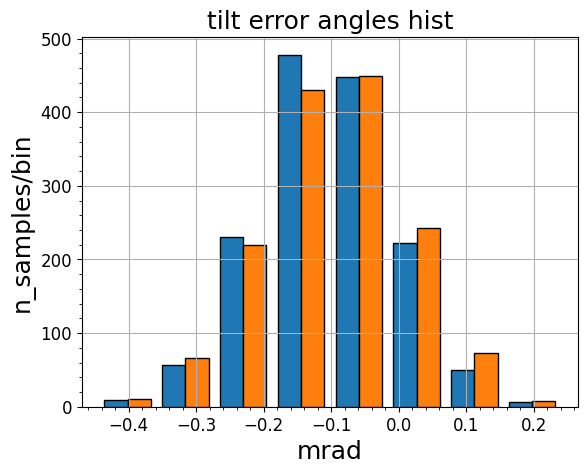

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


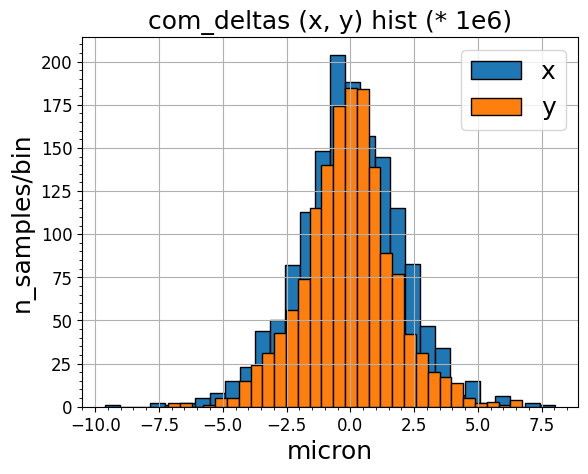

In [18]:
# plt.hist(target_tensors  * 1e6, bins = 20, rwidth=0.8)
plt.hist(target_tensors, bins = 8, edgecolor='black')

title('tilt error angles hist', fontsize=18)
xlabel('mrad', fontsize=18)
ylabel('n_samples/bin', fontsize=18)
tick_params(axis='both', labelsize=14)  # Set font size for ticks
tick_params(axis='both', labelsize=12)  # Optional: Set size for minor ticks
plt.minorticks_on()
grid()
# legend()
plt.savefig(f"./figs/delta_y_error_hist.eps", bbox_inches = 'tight', format='eps')
show()


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))  # Adjust figsize as needed
# com_deltas_x hist
axes[0].hist(np.array(data_automation.com_deltas_x) * 1e6, bins=30, edgecolor='black', color='skyblue')
axes[0].set_title('COM Deltas X Histogram (*1e6)', fontsize=18)
axes[0].set_xlabel('Micron', fontsize=16)
axes[0].set_ylabel('Number of Samples per Bin', fontsize=16)
axes[0].legend(['x'], fontsize=14)
axes[0].tick_params(axis='both', labelsize=14)
axes[0].minorticks_on()

# com_deltas_y hist
axes[1].hist(np.array(data_automation.com_deltas_y) * 1e6, bins=30, edgecolor='black', color='salmon')
axes[1].set_title('COM Deltas Y Histogram (*1e6)', fontsize=18)
axes[1].set_xlabel('Micron', fontsize=16)
axes[1].set_ylabel('Number of Samples per Bin', fontsize=16)
axes[1].legend(['y'], fontsize=14)
axes[1].tick_params(axis='both', labelsize=14)
axes[1].minorticks_on()

plt.tight_layout()

plt.savefig("./figs/com_deltas_error_hist.eps", bbox_inches='tight', format='eps')

plt.show()


In [19]:
# non_zero_idxs = (torch.all(target_tensors, axis=-1)==True).nonzero()
# target_tensors = target_tensors[non_zero_idxs]
# input_tensors = input_tensors[non_zero_idxs]
# input_tensors_scaled = input_tensors_scaled[non_zero_idxs]
# target_tensors_scaled = target_tensors_scaled[non_zero_idxs]


# # target_tensors = torch.squeeze(target_tensors)
# # input_tensors = torch.squeeze(input_tensors)
# # input_tensors_scaled = torch.squeeze(input_tensors_scaled)
# # target_tensors_scaled = torch.squeeze(target_tensors_scaled)

In [20]:
# plt.hist(target_tensors, bins = 20, rwidth=0.8)
# title('delta_y error  hist')
# xlabel('meter')
# grid()
# show()

# plt.hist(np.array(data_automation.com_deltas_y) * 1e6, bins = 20, rwidth=0.8)
# title('com_deltas_y error hist (x 1e6)')
# xlabel('micron')
# grid()
# show()

In [21]:
# input_tensors_scaled.shape

In [22]:
input_tensors.shape

torch.Size([1500, 101, 8, 2])

In [23]:
input_tensors[0].shape

torch.Size([101, 8, 2])

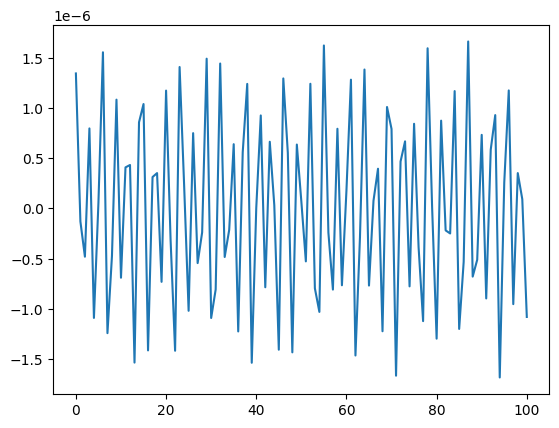

In [49]:
plot(input_tensors[0][:, 0, 1])

In [25]:
target_tensors.shape

torch.Size([1500, 2])

In [26]:
len(data_automation.com_deltas_y)

1500

In [27]:
base_configurations = [data_automation.overridden_base_config]

# Check if data was collected
if input_tensors_scaled is not None and target_tensors_scaled is not None:
    print(f"All Input Tensors Shape: {input_tensors_scaled.shape}")
    print(f"All Target Tensors Shape: {target_tensors_scaled.shape}")
else:
    print("No simulations within the specified delta range.")
    exit(1)  # Exit if no data was collected

# -------------------------------
# Prepare data for training
# -------------------------------

# Reshape input data

raw_input_tensors = input_tensors_scaled # input_tensors_scaled | input_tensors
raw_target_tensors = target_tensors_scaled # target_tensors_scaled | target_tensors

n_samples, n_turns, n_BPMs, n_planes = raw_input_tensors.shape
input_size = n_BPMs * n_planes
input_data = raw_input_tensors.reshape(n_samples, n_turns, input_size)

# Convert target data to appropriate shape
target_data = raw_target_tensors  # Shape: (n_samples, n_errors), where n_errors = 1

# Split data into training and validation sets
input_data_np = input_data.numpy()
target_data_np = target_data.numpy()

train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    input_data_np, target_data_np, test_size=0.20, shuffle=True) #random_state=42

# Convert back to tensors
train_inputs = torch.tensor(train_inputs, dtype=torch.float32)
val_inputs = torch.tensor(val_inputs, dtype=torch.float32)
train_targets = torch.tensor(train_targets, dtype=torch.float32)
val_targets = torch.tensor(val_targets, dtype=torch.float32)

# Create datasets and data loaders
train_dataset = TensorDataset(train_inputs, train_targets)
val_dataset = TensorDataset(val_inputs, val_targets)


All Input Tensors Shape: torch.Size([1500, 101, 8, 2])
All Target Tensors Shape: torch.Size([1500, 2])


In [50]:
train_inputs.shape

torch.Size([1200, 101, 16])

In [24]:
train_targets.shape

torch.Size([1200, 2])

In [25]:
# train_inputs

QuadErrorCorrectionLSTM(
  (lstm): LSTM(16, 32, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)
Epoch [10/800], Train Loss: 0.0545202, Val Loss: 0.0517605, Train MAE: 0.185079, Val MAE: 0.181804, lr: [0.0009999999896710622]
Epoch [20/800], Train Loss: 0.0253417, Val Loss: 0.0240751, Train MAE: 0.12176, Val MAE: 0.117943, lr: [0.0009999999977654136]
Epoch [30/800], Train Loss: 0.00941425, Val Loss: 0.00670954, Train MAE: 0.0667604, Val MAE: 0.053916, lr: [0.000999999999826442]
Epoch [40/800], Train Loss: 0.0050942, Val Loss: 0.0054185, Train MAE: 0.0463851, Val MAE: 0.0494075, lr: [0.0009999999998868076]
Epoch [50/800], Train Loss: 0.00463602, Val Loss: 0.00423501, Train MAE: 0.045435, Val MAE: 0.0462763, lr: [0.0009999999999308537]
Epoch [60/800], Train Loss: 0.00459633, Val Loss: 0.00467584, Train MAE: 0.0445781, Val MAE: 0.0467312, lr: [0.0009999999999157096]
Epoch [70/800], Train Loss: 0.00408466, Val Loss: 0.00491592, 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Epoch [800/800], Train Loss: 2.20252e-05, Val Loss: 0.000564409, Train MAE: 0.00355473, Val MAE: 0.0147369, lr: [0.0009999999999987718]


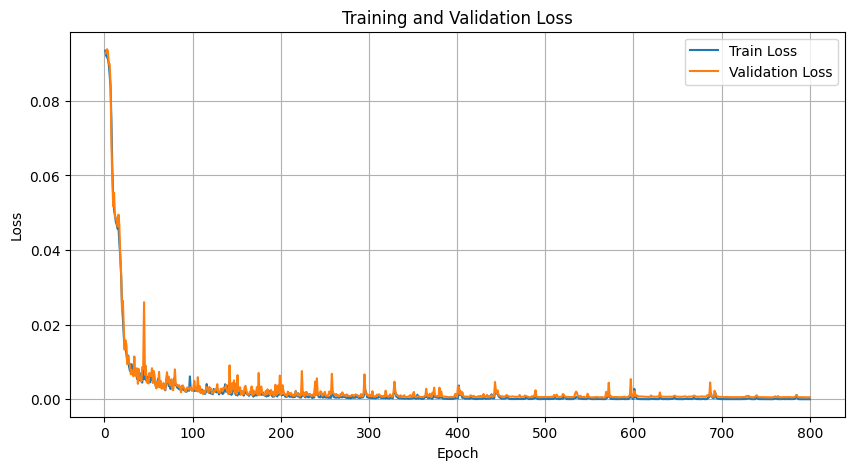

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


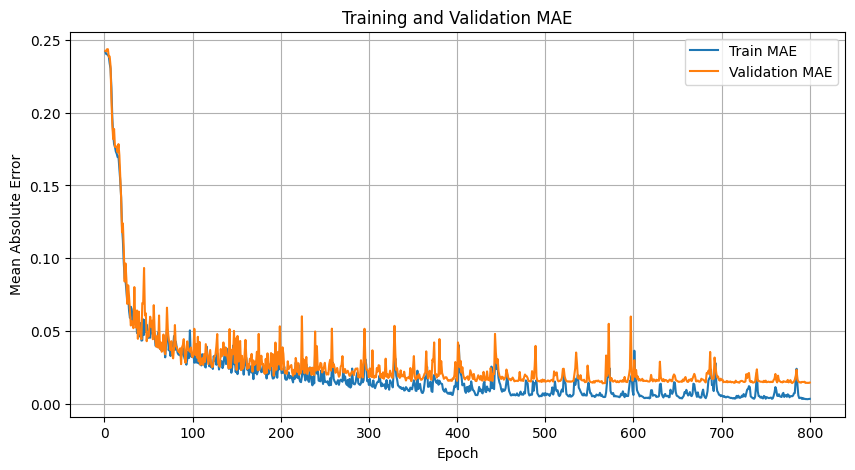

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


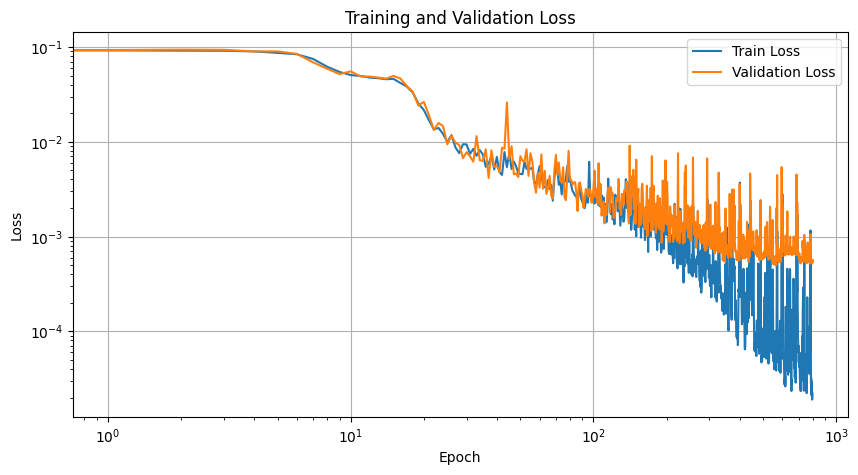

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


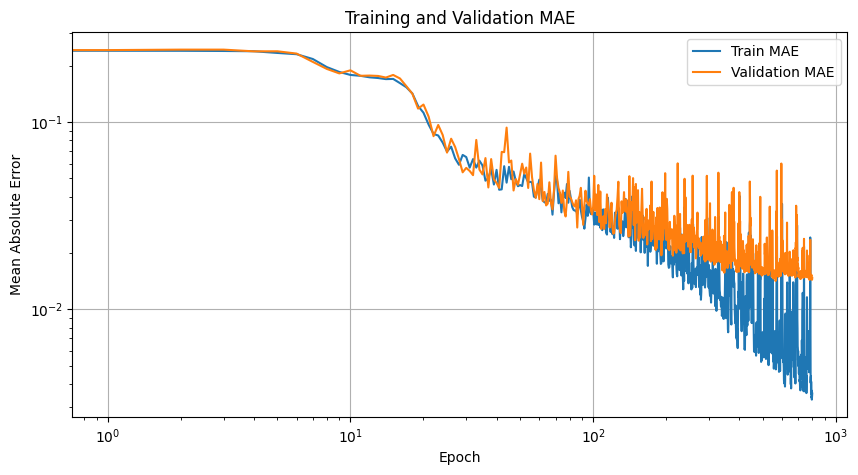

In [53]:
# -------------------------------
# Define the model
# -------------------------------

class QuadErrorCorrectionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, output_size=1, is_bidirectional=False):
        super(QuadErrorCorrectionLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.is_bidirectional = is_bidirectional

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=is_bidirectional)

        # Fully connected layer to map the hidden state to the output
        self.hidden_size_mult = 1
        if self.is_bidirectional:
            self.hidden_size_mult = 2
        self.fc = nn.Linear(hidden_size * self.hidden_size_mult, output_size)

        # Activation function
        # self.tanh = nn.Tanh()

    def forward(self, x):
        # Initialize hidden and cell states with zeros
        h0 = torch.zeros(self.num_layers * self.hidden_size_mult, x.size(0), self.hidden_size).to(x.device)  # Hidden state
        c0 = torch.zeros(self.num_layers * self.hidden_size_mult, x.size(0), self.hidden_size).to(x.device)  # Cell state

        # Forward propagate the LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: (batch_size, seq_length, hidden_size)

        # Use the last time step's output for prediction
        out = out[:, -1, :]  # (batch_size, hidden_size)

        # Pass through the fully connected layer
        out = self.fc(out)  # (batch_size, output_size)

        # out = self.tanh(out)
        return out

class SimpleFullyConnectedNetwork(nn.Module):
    def __init__(self, 
                 input_size, 
                 hidden_size, 
                 output_size, 
                 n_layers=3, 
                 nb_heads=None, 
                 add_batch_norm=False, 
                 add_dropout=False, 
                 down_s_factor=1,
                 act='relu'):
        super(SimpleFullyConnectedNetwork, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.nb_heads = nb_heads
        self.act = act
        
        # Base fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )

        # Downsample factor
        self.down_s_factor = down_s_factor

        self.add_batch_norm = add_batch_norm
        self.add_dropout = add_dropout
        
        for nl in range(1, n_layers+1):
            if nl == 1:
                hdn_siz = self.hidden_size
            else:
                hdn_siz = self.hidden_size // 2**((nl-1)*down_s_factor)
            out_size = self.hidden_size // 2**(nl*down_s_factor)
            
            self.fc.append( nn.Linear(hdn_siz, out_size) )

            if act == 'relu':
                self.fc.append( nn.ReLU() )
            elif act == 'elu':
                self.fc.append( nn.ELU(alpha=1.0) )

            if self.add_batch_norm:
                self.fc.append( nn.BatchNorm1d(out_size) )

            if self.add_dropout:
                self.fc.append( nn.Dropout(p=0.05) )

        if self.nb_heads is None:
            # no heads? add the final output layer directly
            self.fc.add_module('output_layer', nn.Linear(hidden_size // 2**(self.n_layers*down_s_factor), output_size))
        else:
            # ModuleDict for storing multiple head layers
            self.heads = nn.ModuleDict({
                f'head_{ixh}': nn.Linear(hidden_size // 2**(self.n_layers*down_s_factor), 1) 
                for ixh in range(self.nb_heads)
            })

        # Activation functions (if needed)
        # self.tanh = nn.Tanh()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        out = self.fc(x)
        
        if self.nb_heads is not None:
            heads_outs = []
            for head_name, head_fc in self.heads.items():
                out_head = head_fc(out)
                heads_outs.append(out_head)
            
            # Concatenate along the feature dimension (usually dim=1)
            out = torch.cat(heads_outs, dim=1)
        
        # Apply activation (if needed)
        # out = self.tanh(out)
        
        return out


# Instantiate the model

n_samples, n_turns, input_size = train_inputs.shape
output_size = train_targets.shape[1]


batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 'lstm' | 'ffn'
MODEL_ARCH = 'lstm'

if MODEL_ARCH == 'ffn':

    #--------
    # FFN
    #--------
    fnn_hidden_size = 32
    nb_heads = output_size # None
    n_layers = 1
    add_dropout = False
    add_batch_norm = False
    model = SimpleFullyConnectedNetwork(n_turns * input_size, 
                       fnn_hidden_size, 
                       output_size, 
                       n_layers=n_layers , 
                       nb_heads=nb_heads,
                      add_batch_norm=add_batch_norm,
                      add_dropout=add_dropout)


elif MODEL_ARCH == 'lstm':

    #--------
    # LSTM
    #--------
    lstm_hidden_size = 32
    num_layers = 2
    is_bidirectional=True
    model = QuadErrorCorrectionLSTM(
        input_size=input_size,
        hidden_size=lstm_hidden_size,
        num_layers=num_layers,
        output_size=output_size,
        is_bidirectional=is_bidirectional)

model.to(device)

print(model)

# Load checkpoint state_dict
load_checkpoint = False

if load_checkpoint:
    MODEL_LOAD_PATH = f'checkpoints/quad_error_correction_{MODEL_ARCH}.pth'
    chkpnt_state_dict = torch.load(MODEL_LOAD_PATH)
    model.load_state_dict(chkpnt_state_dict)
    print("Checkpoint Loaded.")

else:
        
    
    # model.double()
    
    
    # -------------------------------
    # Define loss function, optimizer, and scheduler
    # -------------------------------
    
    lr = 0.001 
    # lr = 5e-06
    num_epochs = 800  # Adjust as needed
    nb_epoch_log = 10  # Print logs every nb_epoch_log epochs
    
    
    # MSELoss | L1Loss
    
    criterion = nn.MSELoss()
    
    # Adam | AdamW
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    scheduler = None
    
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    #     optimizer, mode='min', factor=0.5, patience=20, verbose=True, min_lr=5e-9
    # )
    
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=5e-10)
    
    # -------------------------------
    # Training loop with evaluation
    # -------------------------------
    
    
    
    def compute_mae(outputs, targets):
        return torch.mean(torch.abs(outputs - targets))
    
    train_losses = []
    val_losses = []
    train_maes = []
    val_maes = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_mae = 0.0
        for batch_inputs, batch_targets in train_loader:
            batch_inputs = batch_inputs.to(device)
            batch_targets = batch_targets.to(device)
    
            optimizer.zero_grad()
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()
    
            train_loss += loss.item() * batch_inputs.size(0)
            train_mae += compute_mae(outputs, batch_targets).item() * batch_inputs.size(0)
    
        train_loss /= len(train_loader.dataset)
        train_mae /= len(train_loader.dataset)
    
        # Evaluation
        model.eval()
        val_loss = 0.0
        val_mae = 0.0
        with torch.no_grad():
            for batch_inputs, batch_targets in val_loader:
                batch_inputs = batch_inputs.to(device)
                batch_targets = batch_targets.to(device)
    
                outputs = model(batch_inputs)
                loss = criterion(outputs, batch_targets)
    
                val_loss += loss.item() * batch_inputs.size(0)
                val_mae += compute_mae(outputs, batch_targets).item() * batch_inputs.size(0)
    
        val_loss /= len(val_loader.dataset)
        val_mae /= len(val_loader.dataset)
    
        if scheduler:
            # Step the scheduler
            scheduler.step(val_loss)
    
        # Record losses for plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_maes.append(train_mae)
        val_maes.append(val_mae)
    
        # Print losses and MAE every nb_epoch_log epochs
        if (epoch + 1) % nb_epoch_log == 0:
            msg_str = f"Epoch [{epoch+1}/{num_epochs}], " \
                  f"Train Loss: {train_loss:.6}, Val Loss: {val_loss:.6}, " \
                  f"Train MAE: {train_mae:.6}, Val MAE: {val_mae:.6}, "
    
            if scheduler:
                msg_str += f"lr: {scheduler.get_last_lr()}"
            print(msg_str)
    
    # Plot training and validation loss
    plt.figure(figsize=(10,5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig("./figs/train_loss.eps", bbox_inches = 'tight', format='eps')
    plt.show()
    
    # Plot training and validation MAE
    plt.figure(figsize=(10,5))
    plt.plot(range(1, num_epochs+1), train_maes, label='Train MAE')
    plt.plot(range(1, num_epochs+1), val_maes, label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.title('Training and Validation MAE')
    plt.legend()
    plt.grid(True)
    plt.savefig("./figs/acc.eps", bbox_inches = 'tight', format='eps')
    plt.show()
    
    
    from pylab import  *
    
    # Plot training and validation loss
    plt.figure(figsize=(10,5))
    loglog(train_losses, label='Train Loss')
    loglog(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig("./figs/train_loss_loglog.eps", bbox_inches = 'tight', format='eps')
    plt.show()
    
    # Plot training and validation MAE
    plt.figure(figsize=(10,5))
    loglog(train_maes, label='Train MAE')
    loglog(val_maes, label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.title('Training and Validation MAE')
    plt.legend()
    plt.grid(True)
    plt.savefig("./figs/acc_loglog.eps", bbox_inches = 'tight', format='eps')
    plt.show()

In [42]:
len(val_loader)

19

[1, 7]
torch.Size([16, 101, 16])


/tmp/ipykernel_4665/2139278264.py:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-gs" (-> color='g'). The keyword argument will take precedence.
  ax.plot(batch_targets[batch_limit_s:batch_limit_e].cpu()[:, quad_idx_pred], '-gs', lw=5, alpha=0.5, color=(0.1, 0.7, 0.1, 0.5))
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


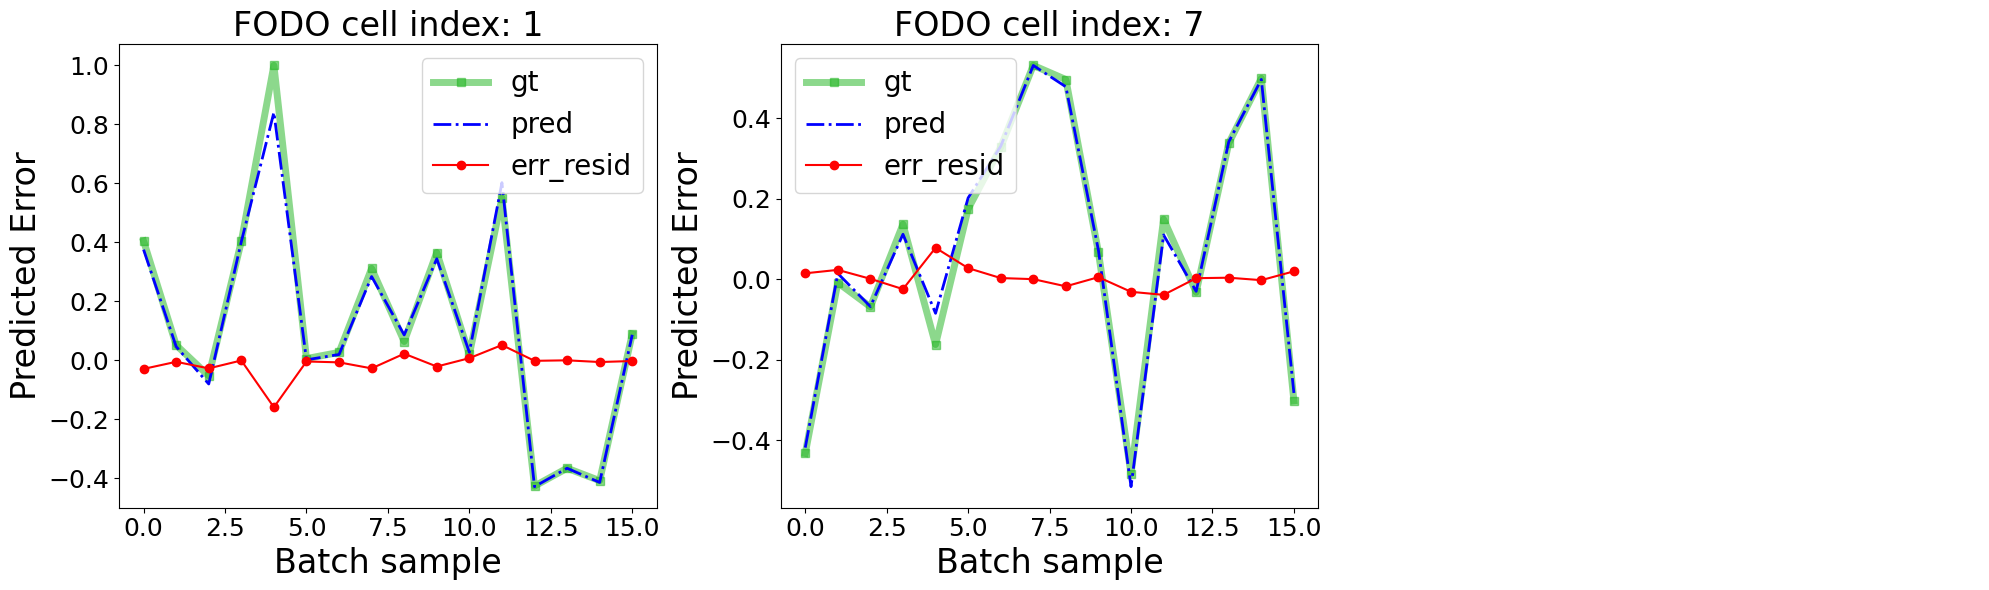

torch.Size([16, 101, 16])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


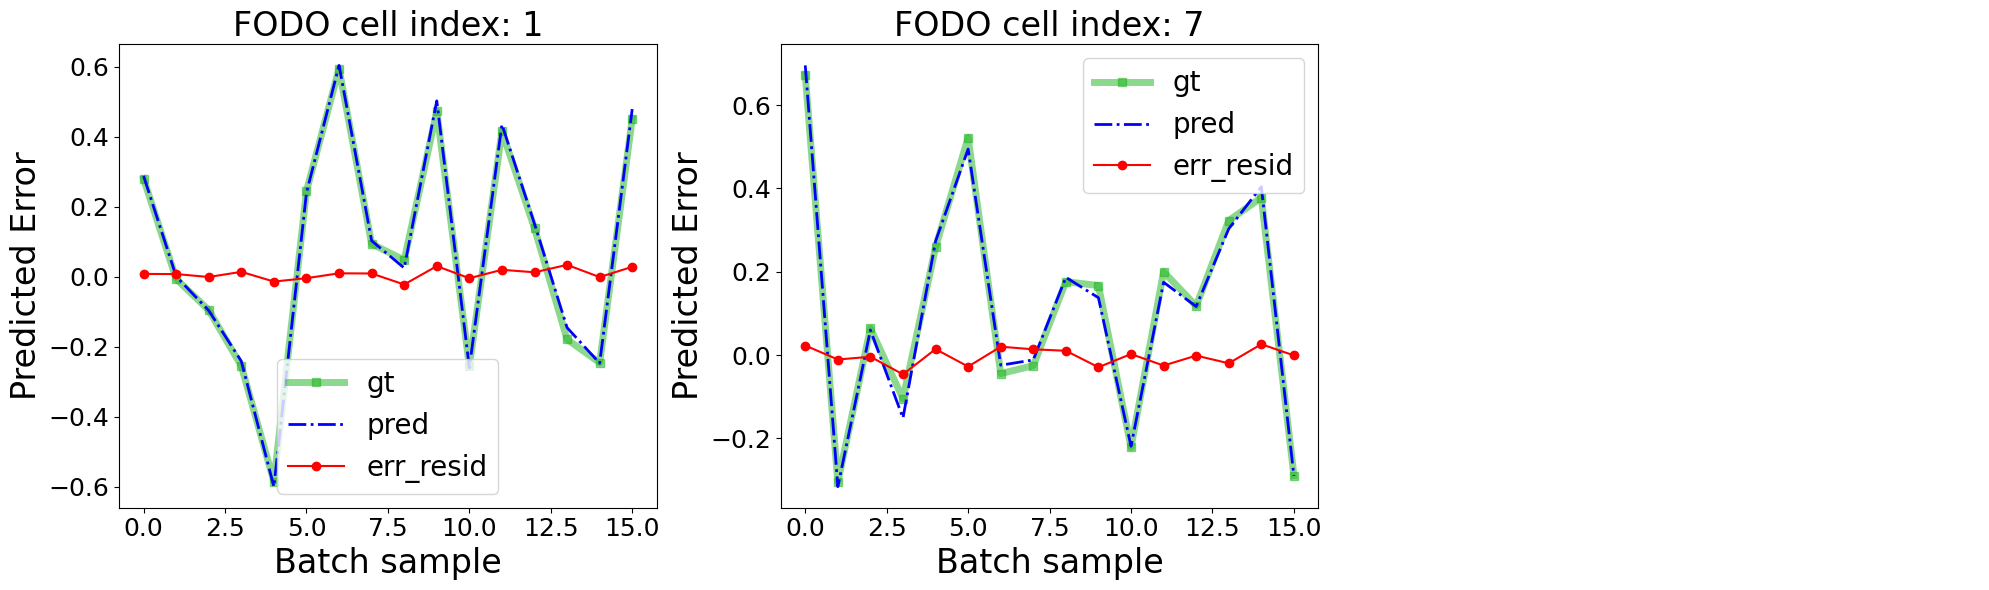

torch.Size([16, 101, 16])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


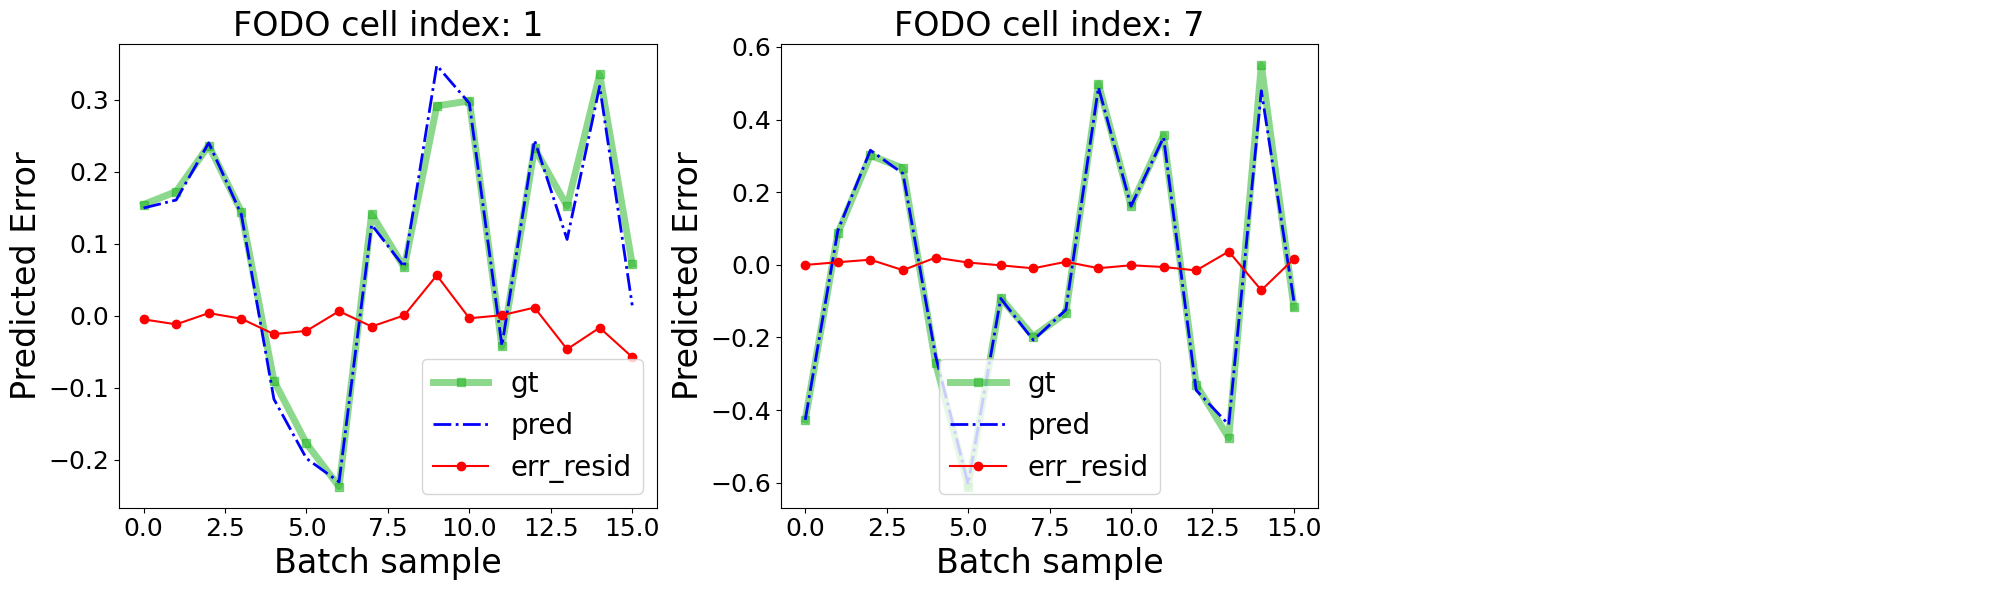

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


torch.Size([16, 101, 16])


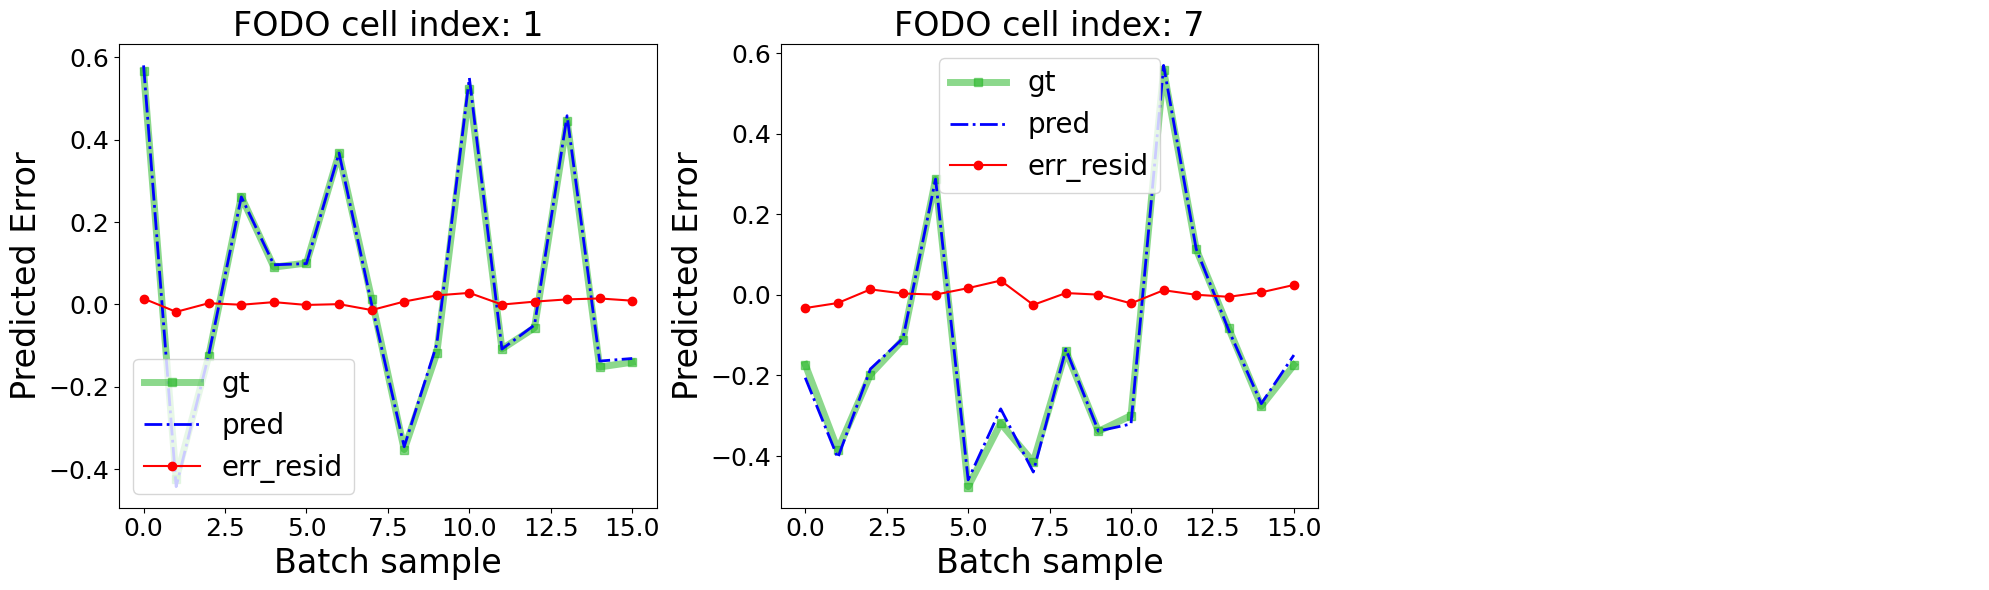

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


torch.Size([16, 101, 16])


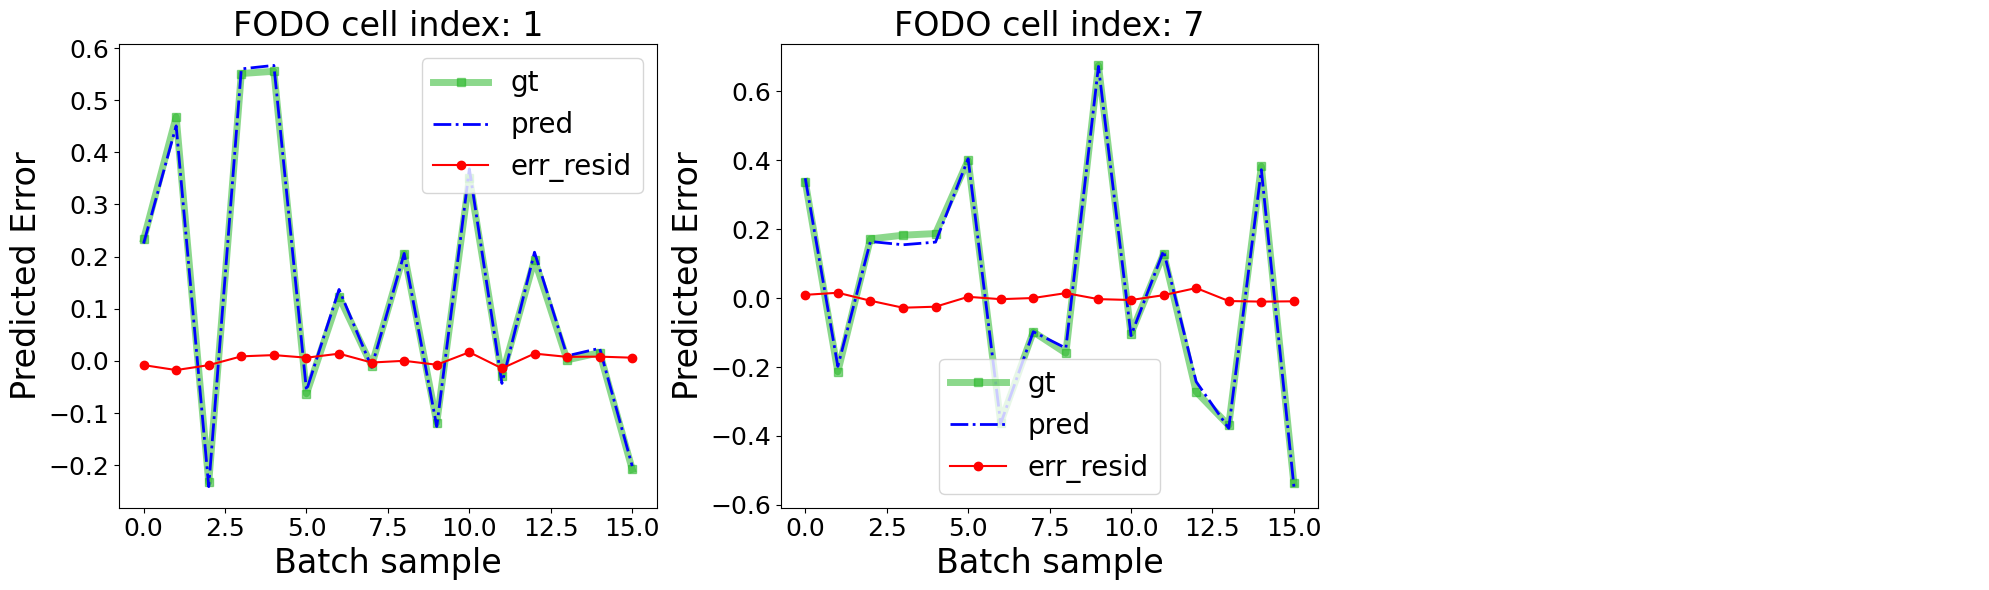

torch.Size([16, 101, 16])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


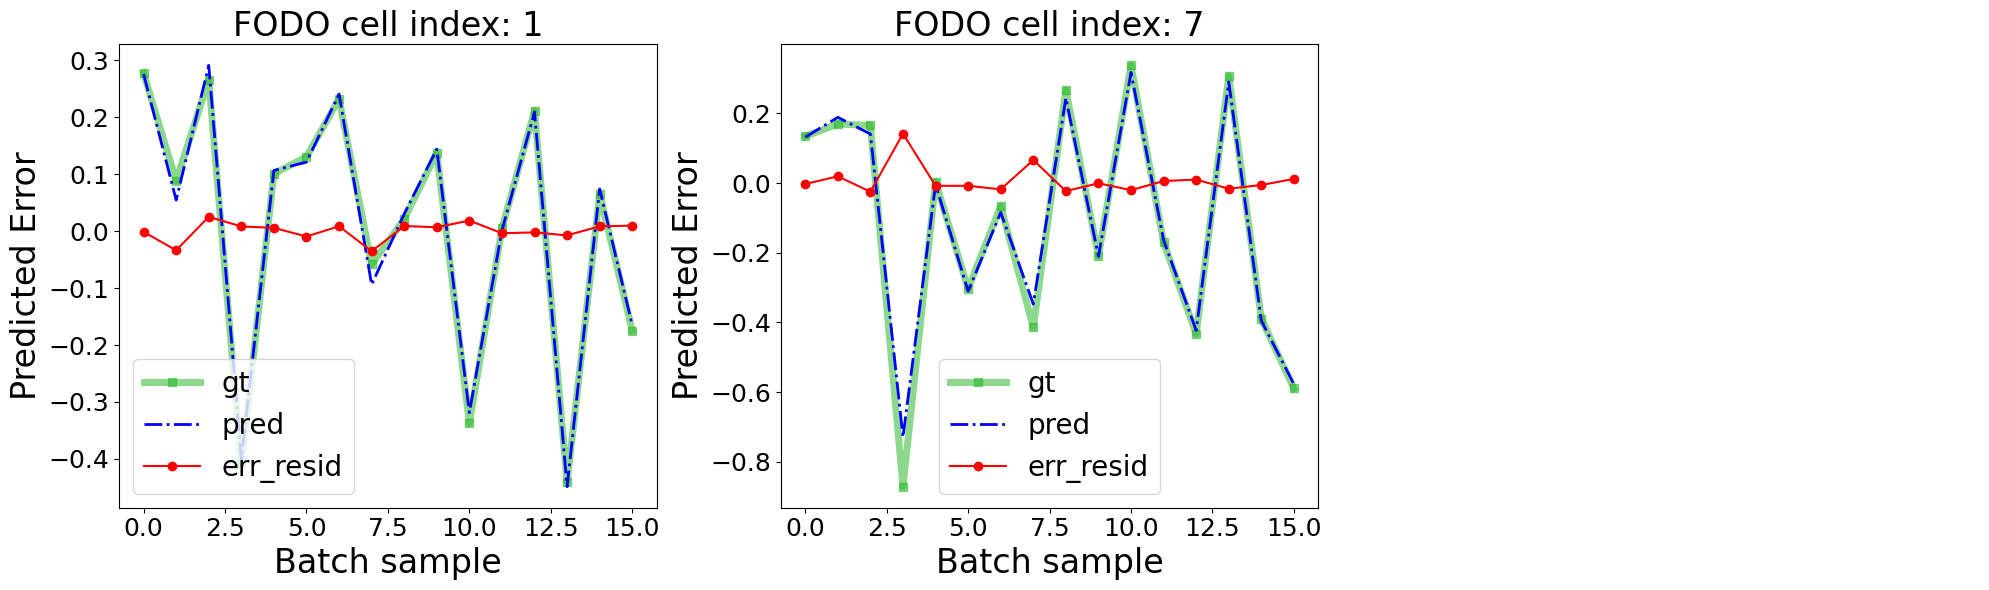

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


torch.Size([16, 101, 16])


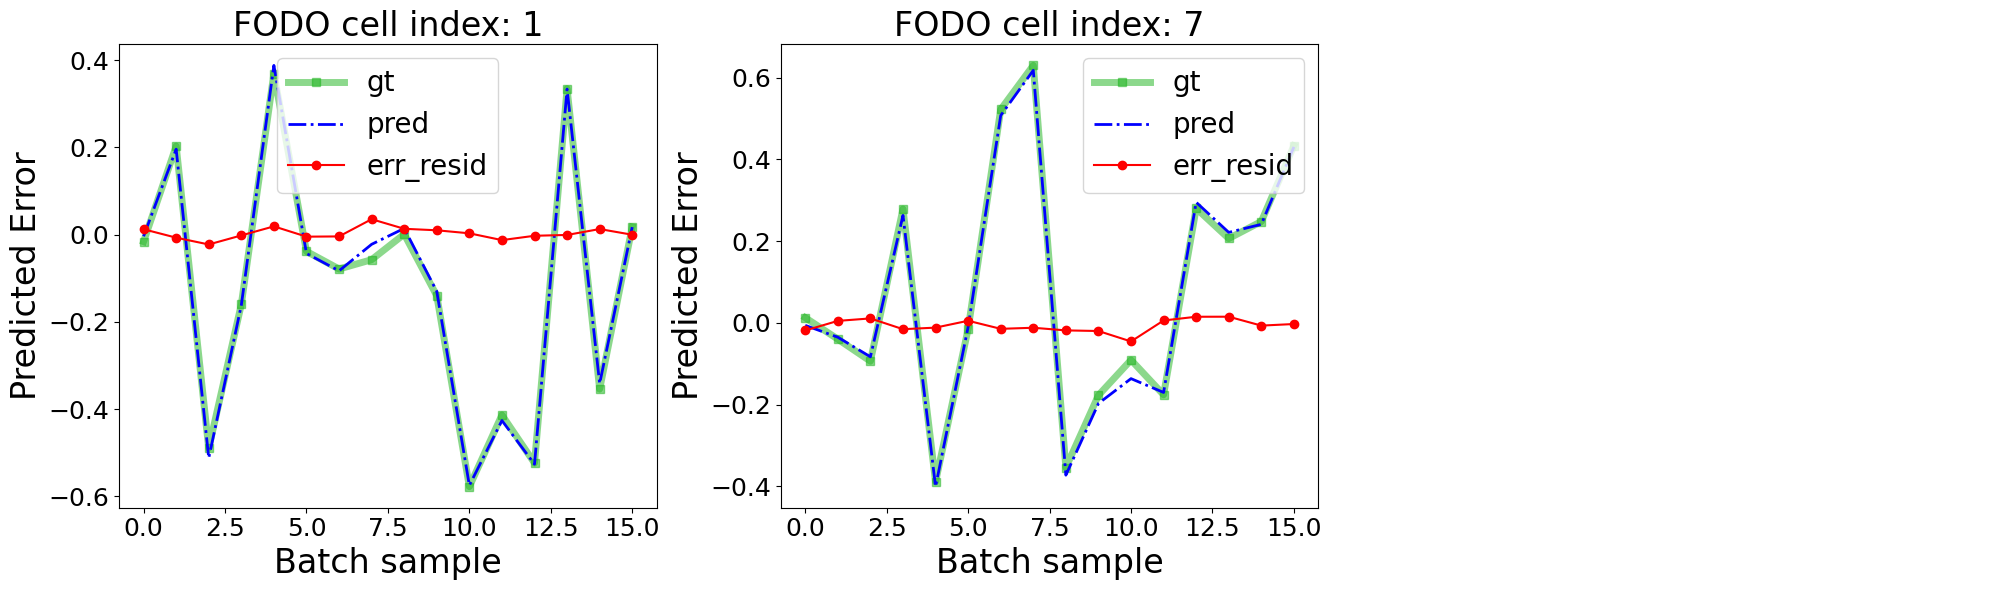

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


torch.Size([16, 101, 16])


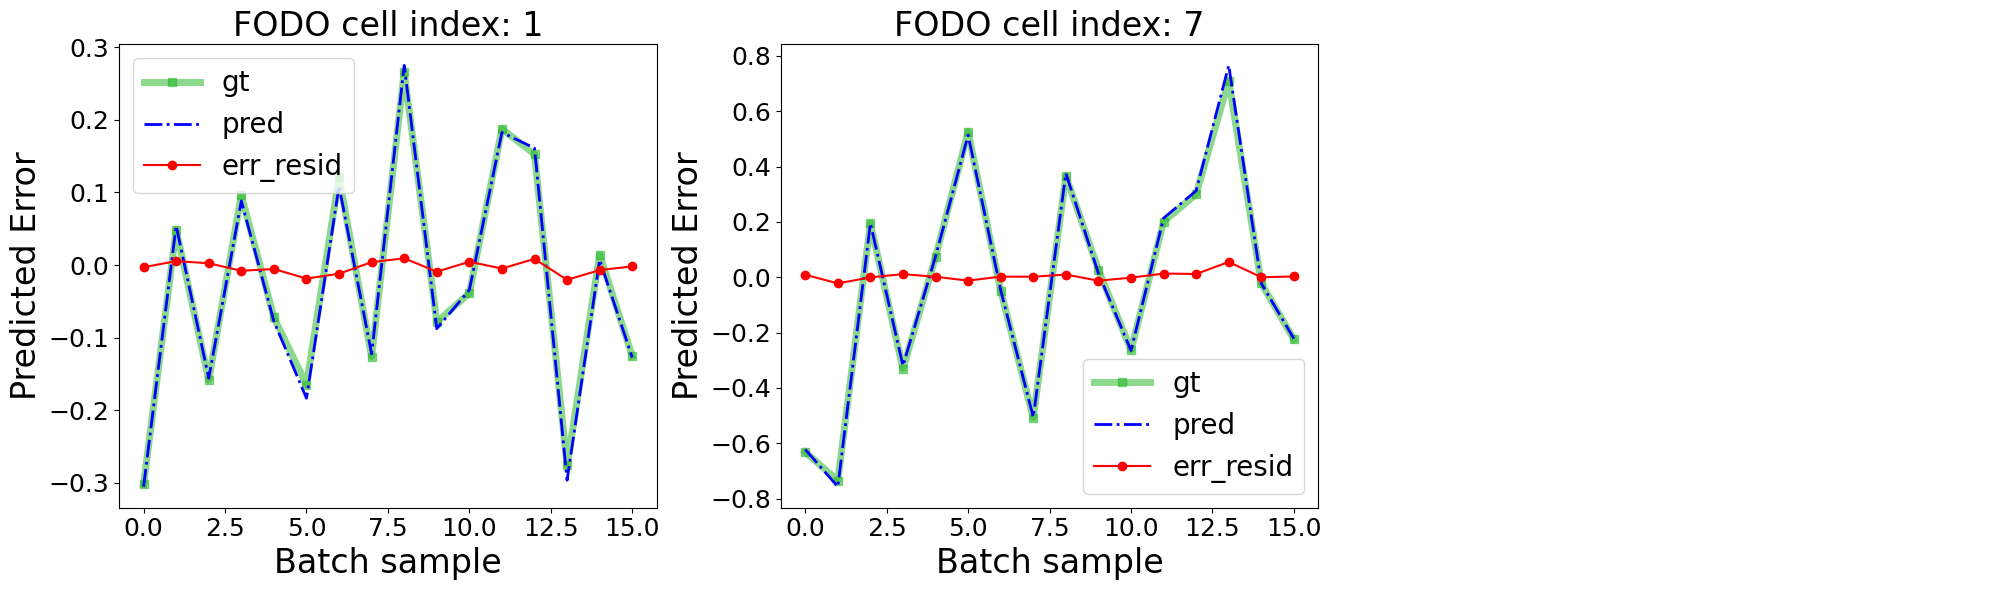

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


torch.Size([16, 101, 16])


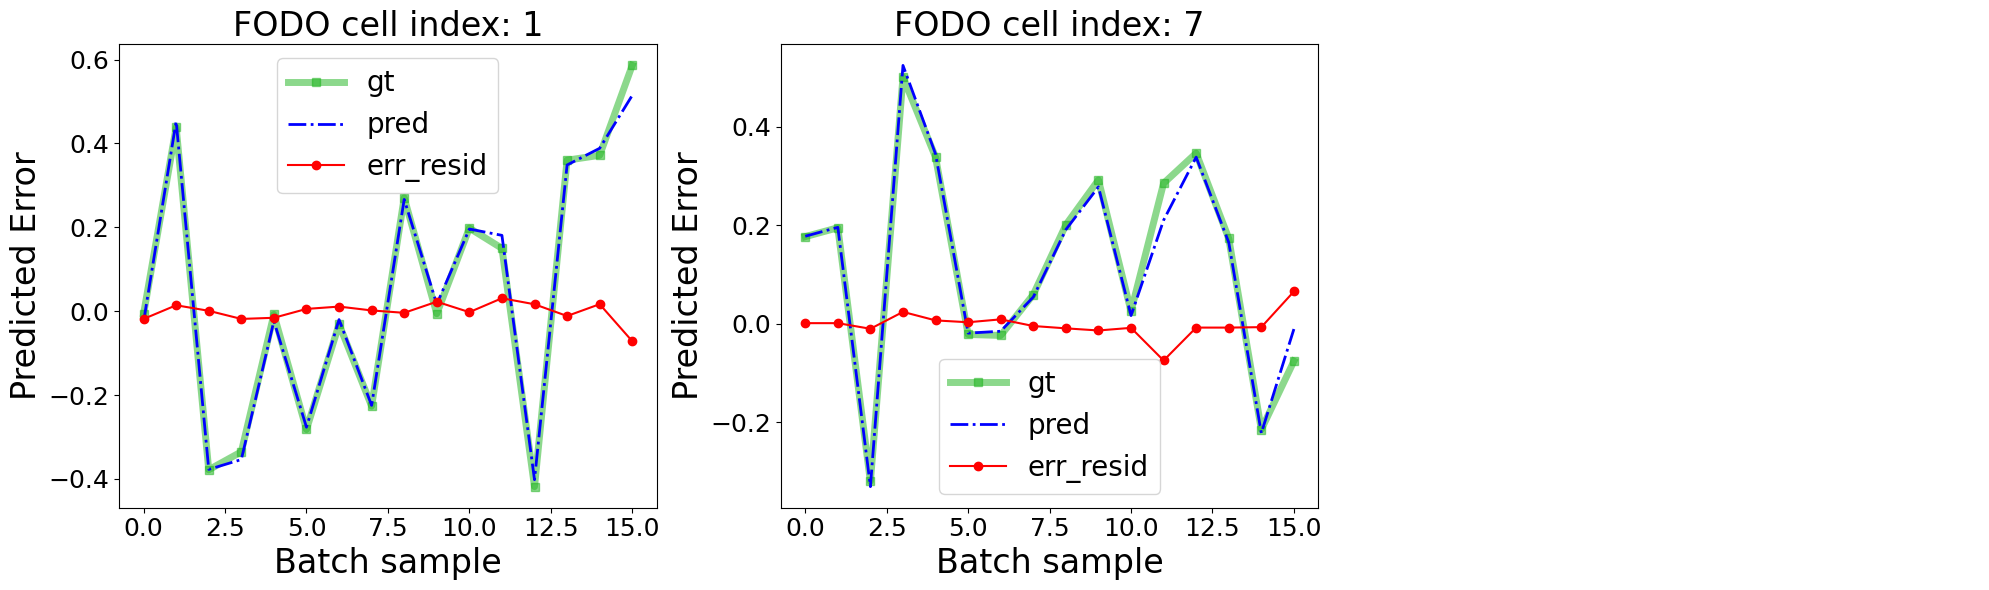

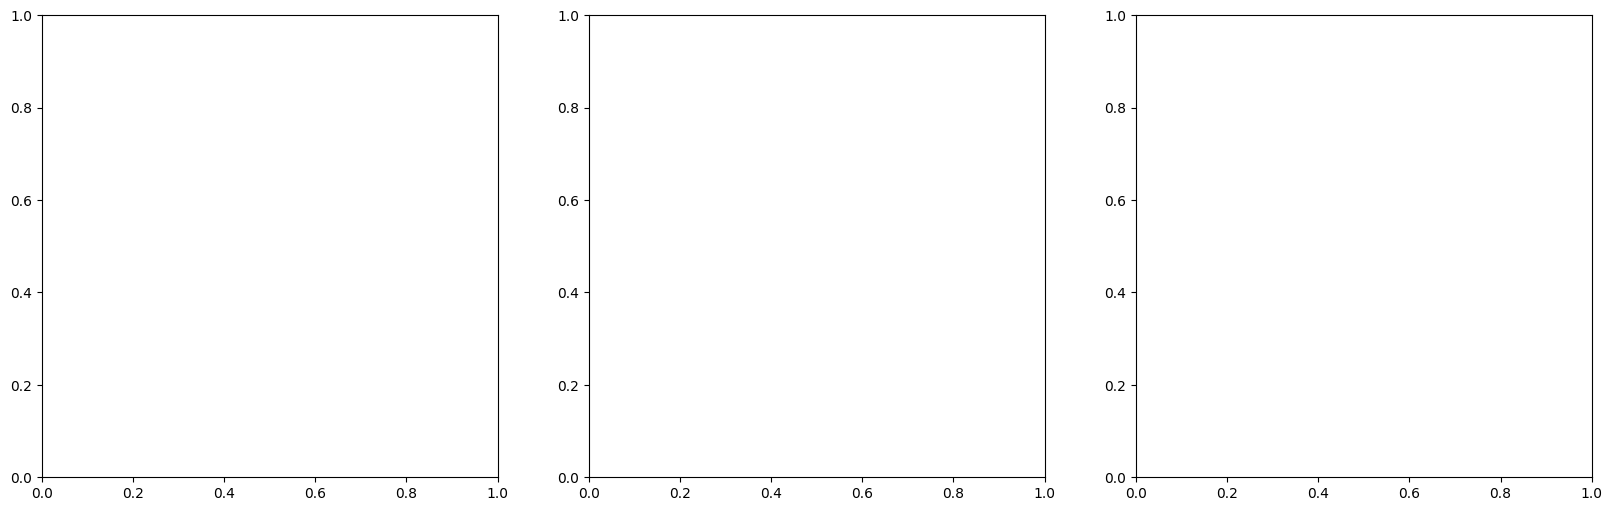

In [54]:
import math

fodo_cell_icdices = [err['FODO_index'] for err in base_configurations[0]['quad_tilt_errors']]
print(fodo_cell_icdices)

batch_limit_s = 0
batch_limit_e = 16
nb_batches = 10
batch_counter = 0

# Number of columns for subplots
cols = 3
rows = math.ceil(len(fodo_cell_icdices) / cols)  # Calculate the number of rows required


for batch_inputs, batch_targets in val_loader:  # train_loader
    fig, axes = plt.subplots(rows, cols, figsize=(20, 6 * rows))  # Adjust figure size as needed
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    batch_counter += 1
    if batch_counter == nb_batches:
        break
    
    print(batch_inputs.shape)
    with torch.no_grad():
        output = model(batch_inputs[batch_limit_s:batch_limit_e].cuda())
    
    err_resid = output.cpu() - batch_targets[batch_limit_s:batch_limit_e].cpu()

    for quad_idx_pred, ax in enumerate(axes[:len(fodo_cell_icdices)]):  # Limit to actual plots
        ax.plot(batch_targets[batch_limit_s:batch_limit_e].cpu()[:, quad_idx_pred], '-gs', lw=5, alpha=0.5, color=(0.1, 0.7, 0.1, 0.5))
        ax.plot(output[:, quad_idx_pred].cpu(), '-.b', lw=2)
        ax.plot(err_resid.cpu()[:, quad_idx_pred], '-or')
        ax.legend(['gt', 'pred', 'err_resid'], fontsize=20)
        ax.set_title(f"FODO cell index: {fodo_cell_icdices[quad_idx_pred]}", fontsize=24)
        ax.set_xlabel("Batch sample", fontsize=24)
        ax.set_ylabel("Predicted Error", fontsize=24)
        ax.tick_params(axis='both', labelsize=18)  # Set font size for ticks
        ax.tick_params(axis='both', labelsize=18)  # Optional: Set size for minor ticks
        plt.minorticks_on()

    # Center empty subplots (if any)
    for empty_ax in axes[len(fodo_cell_icdices):]:
        empty_ax.axis('off')  # Hide unused subplots

    plt.tight_layout()
    plt.savefig(f"./figs/inference_val_batch_{batch_counter}.eps", bbox_inches = 'tight', format='eps')
    plt.show()


In [26]:
output.shape

torch.Size([32, 6])

In [27]:
# predicted_error_value = dataset_scalers['target_scaler'].inverse_transform([[output.cpu()[0][0]]])
# predicted_error_value

In [28]:
# dataset_scalers['target_scaler'].inverse_transform([[-1]])

In [29]:
# dataset_scalers['target_scaler'].inverse_transform([[1]])

In [30]:
-0.0001 #90928

-0.0001

### Save model checkpoint

In [46]:
if not load_checkpoint:
    MODEL_SAVE_PATH = f'checkpoints/quad_tilt_error_correction_{MODEL_ARCH}.pth'
    
    # Save the model's state_dict
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    
    print(f"Model saved to {MODEL_SAVE_PATH}")


Model saved to checkpoints/quad_tilt_error_correction_lstm.pth


In [47]:
base_configurations[0]['quad_errors']

In [48]:
# -------------------------------
# Evaluation function
# -------------------------------

def cumulative_average(self, arr):
    """Calculate the cumulative average of an array."""
    cumsum = np.cumsum(arr)
    cumavg = cumsum / np.arange(1, len(arr) + 1)
    return cumavg


def evaluate_model(model, base_configurations, common_parameters):
    """
    Evaluates the trained model by simulating a new scenario,
    predicting the error, correcting it, and comparing the results.

    Parameters:
    - model: The trained model.
    - base_configurations: Base configurations for the simulation.
    - common_parameters: Common parameters for the simulation.
    """
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 1) Instantiate a new Simulation

    # 2) Define a vertical quadrupole error
    min_delta, max_delta = common_parameters['delta_range']
    
    eval_config = base_configurations[0].copy()

    set_FODO_indices_with_error = [1, 2, 3, 4, 5, 7]
    
    quadrupole_errors_deltas = {}
    for qe_ix, qe in enumerate(eval_config['quad_errors']):
        if eval_config['quad_errors'][qe_ix]['FODO_index'] in set_FODO_indices_with_error:
            quadrupole_error_delta = np.random.normal(min_delta, max_delta)
            quadrupole_errors_deltas[qe_ix] = quadrupole_error_delta
            eval_config['quad_errors'][qe_ix]['delta'] = quadrupole_error_delta
            print(qe_ix, qe)
        else:
            eval_config['quad_errors'][qe_ix]['delta'] = 0.0
    
    print("evaluate_model()/ base_configurations: ", eval_config)

    # Generate initial_states to be used in all simulations
    # Extract initial condition ranges
    # x0_min, x0_max = common_parameters['x0_min_max']
    # xp0_min, xp0_max = common_parameters['xp0_min_max']
    # y0_min, y0_max = common_parameters['y0_min_max']
    # yp0_min, yp0_max = common_parameters['yp0_min_max']

    # num_particles = common_parameters['num_particles']
    # initial_states = []
    # for i in range(num_particles):
    #     x0 = np.random.uniform(x0_min, x0_max)
    #     xp0 = np.random.uniform(xp0_min, xp0_max)
    #     y0 = np.random.uniform(y0_min, y0_max)
    #     yp0 = np.random.uniform(yp0_min, yp0_max)
    #     initial_states.append([x0, xp0, y0, yp0])

    # 4) Simulate without error (baseline) + after applying the error
    # run_configurations() runs both, with and without error simulations.
    sim_runner = SimulationRunner(
        base_configurations=[eval_config],
        common_parameters=common_parameters
    )

    initial_states = None
    
    sim_runner.run_configurations(draw_plots=False, verbose=True, initial_states=initial_states)

    initial_states = sim_runner.initial_states
    
    simulator_no_error = sim_runner.simulators_no_error.get(f"{eval_config['config_name']} - No Error")
    simulator_with_error = sim_runner.simulators_with_error.get(f"{eval_config['config_name']} - With Error")

    # 5) The initial_states are the same in both simulations

    # Create SimulationDataset instance
    simulation_dataset = SimulationDataset(
        bpm_readings_no_error=simulator_no_error.bpm_readings,
        bpm_readings_with_error=simulator_with_error.bpm_readings,
        bpm_positions=simulator_no_error.bpm_positions,
        quadrupole_errors=simulator_with_error.quad_errors,
        lattice_reference=simulator_no_error.get_lattice_reference()
    )

    # Generate data using the same parameters as during training
    start_rev = common_parameters.get('start_rev', 0)
    end_rev = common_parameters.get('end_rev', simulator_no_error.n_turns)
    fodo_cell_indices = common_parameters.get('fodo_cell_indices', list(range(simulator_no_error.n_FODO)))
    planes = common_parameters.get('planes', ['x, y'])

    print(f"[Evaluation - Generate data params:]\n"
        f"\t start_rev={start_rev}\n"
        f"\t end_rev={end_rev}\n"
        f"\t fodo_cell_indices={fodo_cell_indices}\n"
        f"\t planes={planes}")
    
    input_tensor, _ = simulation_dataset.generate_data(
        start_rev, end_rev, fodo_cell_indices, planes
    )

    # Reshape input data to match model input
    n_samples, n_turns, n_BPMs, n_planes = input_tensor.shape
    input_size = n_BPMs * n_planes
    input_data = input_tensor.reshape(n_samples, n_turns, input_size)

    # **Reshape input data back to (n_samples, n_turns, n_BPMs, n_planes)**
    input_data_reshaped = input_data.reshape(n_samples, n_turns, n_BPMs, n_planes)

    # **Reshape to (-1, n_planes) for scaling**
    input_data_flat = input_data_reshaped.reshape(-1, n_planes)  # Shape: (n_samples * n_turns * n_BPMs, n_planes)

    # **Use the input scaler to transform the input data**
    input_data_flat_scaled = dataset_scalers['input_scaler'].transform(input_data_flat)

    # **Reshape back to (n_samples, n_turns, n_BPMs, n_planes)**
    input_data_scaled = input_data_flat_scaled.reshape(n_samples, n_turns, n_BPMs, n_planes)

    # **Flatten to (n_samples, n_turns, input_size) for model input**
    input_data_scaled = input_data_scaled.reshape(n_samples, n_turns, input_size)

    # Convert to tensor
    input_tensor = torch.tensor(input_data_scaled, dtype=torch.float32).to(device)


    # Predict the error
    model.eval()
    with torch.no_grad():
        print("input to model: ", input_tensor.shape)
        predicted_error = model(input_tensor)  # predicted_error shape: (n_samples, output_size)
        print("predicted_errors = ", predicted_error)
        predicted_errors_scaled_values = predicted_error.cpu().numpy()

    # Inverse transform the prediction
    # predicted_errors_values_tranformed_back = {}
    predicted_errors_values_tranformed_back = dataset_scalers['target_scaler'].inverse_transform(predicted_errors_scaled_values)
    predicted_errors_values_tranformed_back = predicted_errors_values_tranformed_back.flatten()
    print(f"predicted_errors_values_tranformed_back = {predicted_errors_values_tranformed_back}")
    
    for pesv_ix, pesv in enumerate(predicted_errors_values_tranformed_back):
        predicted_error_value = pesv
        predicted_errors_values_tranformed_back[pesv_ix] = pesv
        print(f'error: {pesv_ix}')
        
        if pesv_ix not in quadrupole_errors_deltas:
            print(f"WARNING - error prediction output with index={pesv_ix}, is not available.\n\tthis may idicate that you set custom error config rather than the trained network")
            continue
        print(f"\tActual quadrupole error delta: {quadrupole_errors_deltas[pesv_ix]:.7e}, {quadrupole_errors_deltas[pesv_ix] * 1e6}")
        print(f"\tPredicted quadrupole error delta: {predicted_error_value:.7e}, {predicted_error_value * 1e6}")
        print('---')

    # 7) Apply correction and re-run simulation
    # Correct the quadrupole error by subtracting the predicted error
    corrected_deltas = {}
    for pevtb_ix, pevtb in enumerate(predicted_errors_values_tranformed_back):
        if pevtb_ix not in quadrupole_errors_deltas:
            print(f"WARNING - error prediction output with index={pesv_ix}, is not available.\n\tthis may idicate that you set custom error config rather than the trained network")
            # If error was not found, we assume it is 0
            corrected_deltas[pevtb_ix] = 0.0
            continue
        corrected_delta = quadrupole_errors_deltas[pevtb_ix] - predicted_errors_values_tranformed_back[pevtb_ix]
        corrected_deltas[pevtb_ix] = corrected_delta
    
    
    print(f"\tCorrected_delta quadrupole error delta [0]: {corrected_delta:.7e}, {corrected_delta * 1e6}")
    
    eval_config_corrected = eval_config.copy()
    for cord_ix, cord in corrected_deltas.items():
        print(cord_ix, cord)
        eval_config_corrected['quad_errors'][cord_ix]['delta'] = cord

    runner_corrected = SimulationRunner(
        base_configurations=[eval_config_corrected],
        common_parameters=common_parameters
    )

    runner_corrected.run_configurations(draw_plots=False, verbose=False, initial_states=initial_states)
    simulator_corrected = runner_corrected.simulators_with_error.get(f"{eval_config_corrected['config_name']} - With Error")

    # 8) Compare y positions after applying the correction with the original simulation without errors
    # Use the same start_rev and end_rev

    # Extract BPM readings for comparison
    bpm_readings_no_error = simulator_no_error.bpm_readings['y'][:, start_rev:end_rev, :][:, :, fodo_cell_indices].mean(axis=0)  # Shape: [n_turns, n_BPMs]
    bpm_readings_with_error = simulator_with_error.bpm_readings['y'][:, start_rev:end_rev, :][:, :, fodo_cell_indices].mean(axis=0)  # Shape: [n_turns, n_BPMs]
    bpm_readings_corrected = simulator_corrected.bpm_readings['y'][:, start_rev:end_rev, :][:, :, fodo_cell_indices].mean(axis=0)  # Shape: [n_turns, n_BPMs]

    # Cumulative average
    # bpm_readings_no_error_cumu = cumulative_average(bpm_readings_no_error)
    # bpm_readings_with_error_cumu = cumulative_average(bpm_readings_with_error)
    # bpm_readings_corrected_cumu = cumulative_average(bpm_readings_corrected)

    bpm_indx = 0
    rev_numbers = np.arange(end_rev - 100, end_rev)
    print(f"rev_numbers = {rev_numbers}")
    print(f"bpm_readings_no_error = {bpm_readings_no_error.shape}")

    # Plot the comparison
    plt.figure(figsize=(12, 6))
    plt.plot(rev_numbers, bpm_readings_no_error[:,bpm_indx][bpm_readings_no_error.shape[0] - 100:], '-o', label='No Error', color='blue')
    plt.plot(rev_numbers, bpm_readings_with_error[:,bpm_indx][bpm_readings_with_error.shape[0] - 100:], '-x', label='With Error', color='red')
    plt.plot(rev_numbers, bpm_readings_corrected[:,bpm_indx][bpm_readings_corrected.shape[0] - 100:], '-v', label='After Correction', color='green')
    plt.xlabel('Turn')
    plt.ylabel(f'Average y position at BPM {bpm_indx}')
    plt.title('Comparison of y positions after correction')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Compute and print the residual error after correction
    residual_error = np.abs(bpm_readings_no_error - bpm_readings_corrected).mean()
    print(f"Residual error after correction (mean absolute difference): {residual_error:.6e}, {residual_error * 1e6}")
    
    # simulator_with_error.plot_comparison(simulator_no_error, cell_idx=bpm_indx, viz_start_idx=start_rev, viz_end_idx=end_rev)
    # simulator_with_error.plot_comparison(simulator_corrected, cell_idx=bpm_indx, viz_start_idx=start_rev, viz_end_idx=end_rev)

    simulator_with_error.plot_comparison(simulator_no_error, cell_idx=bpm_indx, viz_start_idx=end_rev - 100, viz_end_idx=end_rev, save_label="WOEvsWE")
    simulator_corrected.plot_comparison(simulator_no_error, cell_idx=bpm_indx, viz_start_idx=end_rev - 100, viz_end_idx=end_rev, save_label="WOEvsC")

    simulator_no_error.plot_bpm_heatmaps(cell_idx=0)
    simulator_with_error.plot_bpm_heatmaps(cell_idx=0)
    simulator_corrected.plot_bpm_heatmaps(cell_idx=0)

    cell_idx = 0
    simulator_corrected.plot_bpm_comparison_last_images(simulator_corrected, simulator_with_error, cell_idx=cell_idx, save_label="WEvsC", particles='last')
    simulator_corrected.plot_bpm_comparison_last_images(simulator_corrected, simulator_no_error, cell_idx=cell_idx, save_label="WOEvsC", particles='last')

    return simulator_no_error, simulator_with_error, simulator_corrected


In [34]:
# dataset_scalers['target_scaler'].inverse_transform(np.array([0.23, 1, 1]).reshape(1, -1))[0, 0]

In [35]:
# eval_config = base_configurations.copy()
# for qe_ix, qe in enumerate(eval_config[0]['quad_errors']):
#     eval_config[0]['quad_errors'][qe_ix]['delta'] = 0
#     print(qe_ix, qe)

0 {'FODO_index': 1, 'quad_type': 'defocusing', 'delta': 5.631673419922034e-05, 'plane': 'vertical'}
1 {'FODO_index': 2, 'quad_type': 'defocusing', 'delta': 2.3594085621436486e-05, 'plane': 'vertical'}
2 {'FODO_index': 3, 'quad_type': 'defocusing', 'delta': -3.256632452196796e-05, 'plane': 'vertical'}
3 {'FODO_index': 4, 'quad_type': 'defocusing', 'delta': -6.532246220350643e-05, 'plane': 'vertical'}
4 {'FODO_index': 5, 'quad_type': 'defocusing', 'delta': 5.0546564310888024e-05, 'plane': 'vertical'}
5 {'FODO_index': 7, 'quad_type': 'defocusing', 'delta': 2.8330455352042817e-05, 'plane': 'vertical'}
evaluate_model()/ base_configurations:  {'config_name': 'Configuration 1', 'design_radius': 20.0, 'n_FODO': 8, 'f': 3.336008739076155, 'L_quad': 1, 'L_straight': 3.9269908169872423, 'quad_errors': [{'FODO_index': 1, 'quad_type': 'defocusing', 'delta': 5.631673419922034e-05, 'plane': 'vertical'}, {'FODO_index': 2, 'quad_type': 'defocusing', 'delta': 2.3594085621436486e-05, 'plane': 'vertical'}

/home/aribra/jnps/thesis/lattice_error_net/synchrotron_simulator_gpu_Dataset_4D.py:1102: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X_hor = np.random.multivariate_normal(mean=[0,0], cov=Sigma_x, size=num_particles)
/home/aribra/jnps/thesis/lattice_error_net/synchrotron_simulator_gpu_Dataset_4D.py:1104: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X_ver = np.random.multivariate_normal(mean=[0,0], cov=Sigma_y, size=num_particles)
/home/aribra/.local/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))



Running Configuration 1 - With Error:
  n_FODO=8, design_radius=20.0m, f=3.336008739076155m, L_quad=1m, L_straight=3.9269908169872423m
['Drift Before Dipole #0', 'Dipole #0', 'Drift After Dipole #0', 'Defocusing Quad', 'Drift Before Dipole #1', 'Dipole #1', 'Drift After Dipole #1', 'Focusing Quad']
build_lattice() completed. Total elements per rev = 64
0.28129690495610365 0.2812969049561037
['Drift Before Dipole #0', 'Dipole #0', 'Drift After Dipole #0', 'Defocusing Quad', 'Drift Before Dipole #1', 'Dipole #1', 'Drift After Dipole #1', 'Focusing Quad']
Applied old Quad misalignment at cell=1, quad=defocusing, plane=vertical, delta=5.631673419922034e-05, theta_kick=-1.6881470824568704e-05
Applied old Quad misalignment at cell=2, quad=defocusing, plane=vertical, delta=2.3594085621436486e-05, theta_kick=-7.072549104883467e-06
Applied old Quad misalignment at cell=3, quad=defocusing, plane=vertical, delta=-3.256632452196796e-05, theta_kick=9.762062113478332e-06
Applied old Quad misalignme

/home/aribra/.local/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


[Evaluation - Generate data params:]
	 start_rev=1000
	 end_rev=1500
	 fodo_cell_indices=[0, 1, 2, 3, 4, 5, 6, 7]
	 planes=['x', 'y']
input to model:  torch.Size([1, 101, 16])
predicted_errors =  tensor([[0.4051, 0.4862, 0.1030, 0.0058, 0.6314, 0.2976]], device='cuda:0')
predicted_errors_values_tranformed_back = [ 5.6268873e-05  2.4631636e-05 -3.3734101e-05 -6.4650434e-05
  5.0589104e-05  2.8102246e-05]
error: 0
	Actual quadrupole error delta: 5.6316734e-05, 56.31673419922034
	Predicted quadrupole error delta: 5.6268873e-05, 56.26887286780402
---
error: 1
	Actual quadrupole error delta: 2.3594086e-05, 23.594085621436488
	Predicted quadrupole error delta: 2.4631636e-05, 24.631635824334808
---
error: 2
	Actual quadrupole error delta: -3.2566325e-05, -32.56632452196796
	Predicted quadrupole error delta: -3.3734101e-05, -33.734100725268945
---
error: 3
	Actual quadrupole error delta: -6.5322462e-05, -65.32246220350643
	Predicted quadrupole error delta: -6.4650434e-05, -64.65043406933546
--

/home/aribra/.local/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


['Drift Before Dipole #0', 'Dipole #0', 'Drift After Dipole #0', 'Defocusing Quad', 'Drift Before Dipole #1', 'Dipole #1', 'Drift After Dipole #1', 'Focusing Quad']
build_lattice() completed. Total elements per rev = 64
0.28129690495610365 0.2812969049561037
['Drift Before Dipole #0', 'Dipole #0', 'Drift After Dipole #0', 'Defocusing Quad', 'Drift Before Dipole #1', 'Dipole #1', 'Drift After Dipole #1', 'Focusing Quad']
Applied old Quad misalignment at cell=1, quad=defocusing, plane=vertical, delta=4.786133141632137e-08, theta_kick=-1.4346884303898935e-08
Applied old Quad misalignment at cell=2, quad=defocusing, plane=vertical, delta=-1.0375502028983212e-06, theta_kick=3.1101543312672835e-07
Applied old Quad misalignment at cell=3, quad=defocusing, plane=vertical, delta=1.1677762033009858e-06, theta_kick=-3.500519017298436e-07
Applied old Quad misalignment at cell=4, quad=defocusing, plane=vertical, delta=-6.720281341709739e-07, theta_kick=2.0144675470996502e-07
Applied old Quad misali

/home/aribra/.local/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


rev_numbers = [1400 1401 1402 1403 1404 1405 1406 1407 1408 1409 1410 1411 1412 1413
 1414 1415 1416 1417 1418 1419 1420 1421 1422 1423 1424 1425 1426 1427
 1428 1429 1430 1431 1432 1433 1434 1435 1436 1437 1438 1439 1440 1441
 1442 1443 1444 1445 1446 1447 1448 1449 1450 1451 1452 1453 1454 1455
 1456 1457 1458 1459 1460 1461 1462 1463 1464 1465 1466 1467 1468 1469
 1470 1471 1472 1473 1474 1475 1476 1477 1478 1479 1480 1481 1482 1483
 1484 1485 1486 1487 1488 1489 1490 1491 1492 1493 1494 1495 1496 1497
 1498 1499]
bpm_readings_no_error = (500, 8)


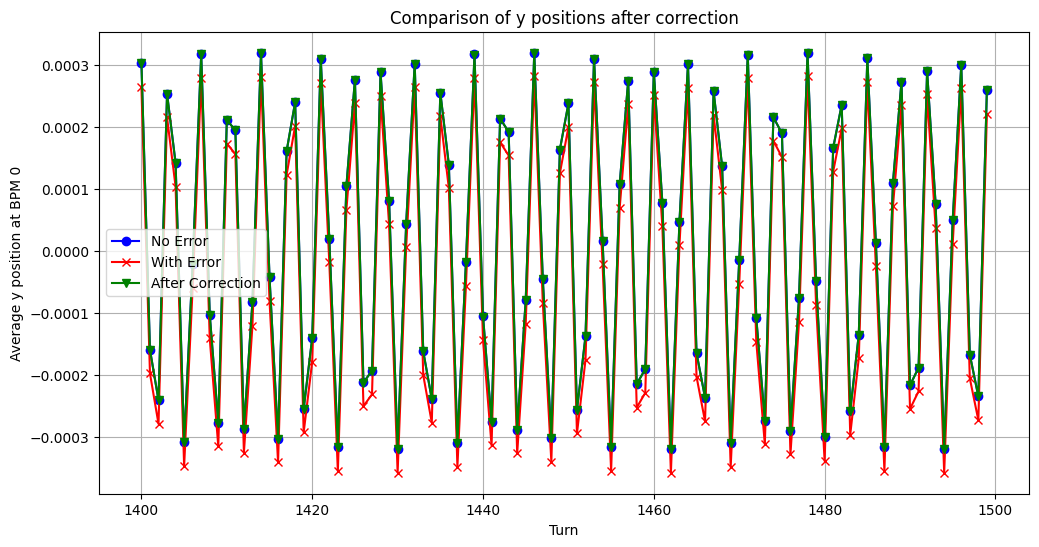

Residual error after correction (mean absolute difference): 1.359344e-07, 0.1359343841666486
plot_comparison()/
	 CoM No error: X = -1.1231487162196267e-08, Y = -3.815689545366771e-05
	 CoM With Error: X = -1.1231487162196267e-08, Y = -4.2804372014313636e-08
----
	 ΔX = 0.0000000 m, 0.00 micron
	 ΔY = 0.0000381 m, 38.11 micron
----
	 ΔX cumu = 0.00 micron
	 ΔY cumu = 38.11 micron


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


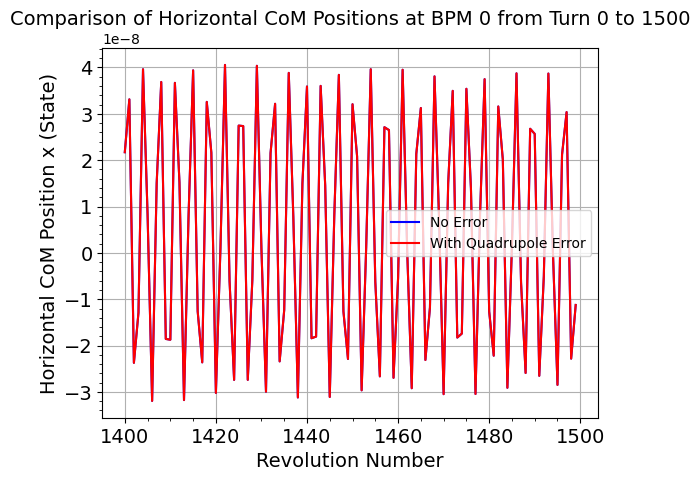

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


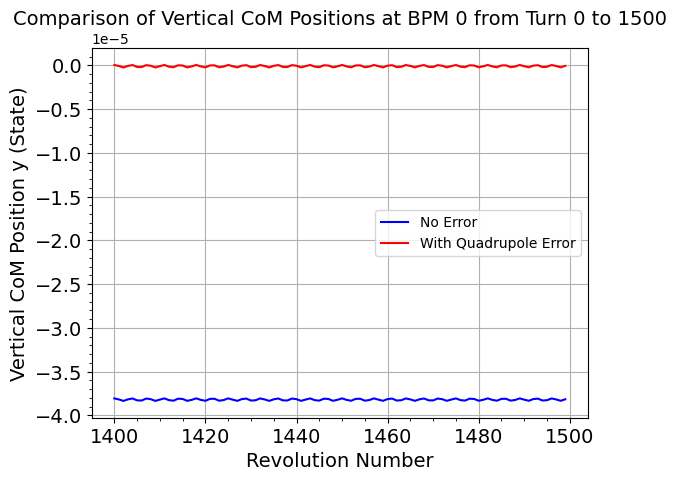

plot_comparison()/
	 CoM No error: X = -1.1231487162196267e-08, Y = -8.896908770010352e-08
	 CoM With Error: X = -1.1231487162196267e-08, Y = -4.2804372014313636e-08
----
	 ΔX = 0.0000000 m, 0.00 micron
	 ΔY = 0.0000000 m, 0.05 micron
----
	 ΔX cumu = 0.00 micron
	 ΔY cumu = 0.05 micron


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


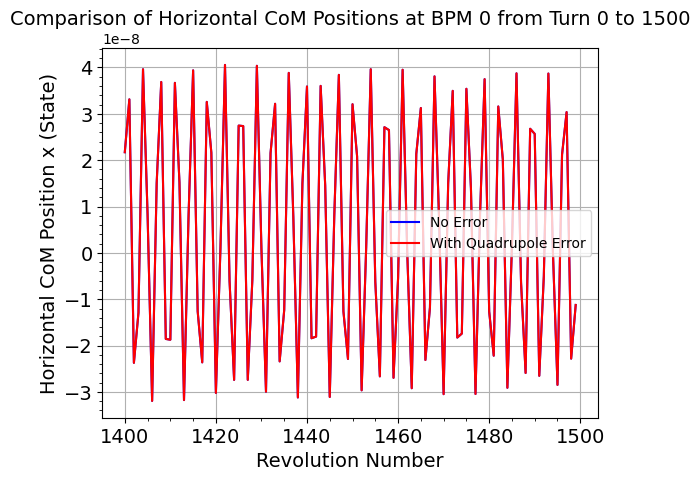

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


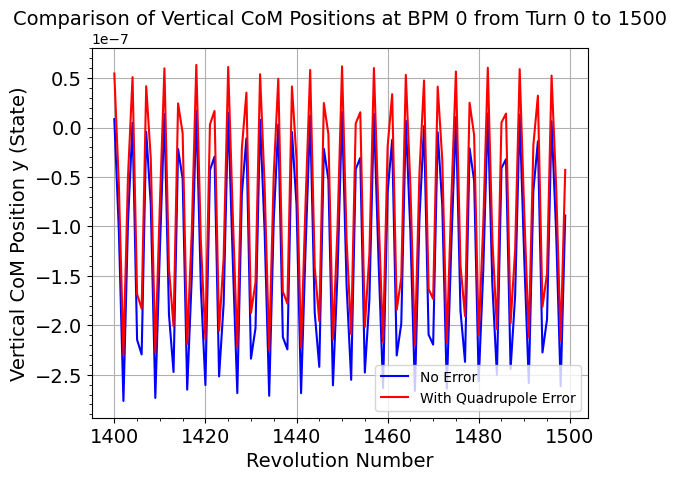

/home/aribra/jnps/thesis/lattice_error_net/synchrotron_simulator_gpu_Dataset_4D.py:2024: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


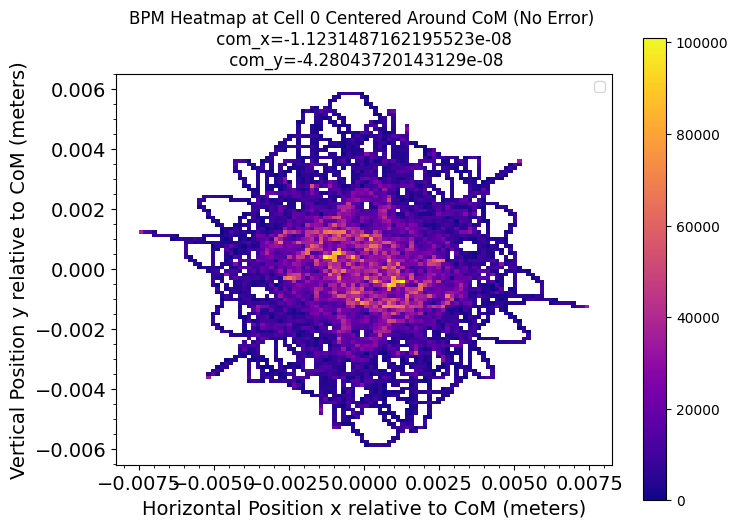

/home/aribra/jnps/thesis/lattice_error_net/synchrotron_simulator_gpu_Dataset_4D.py:2024: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


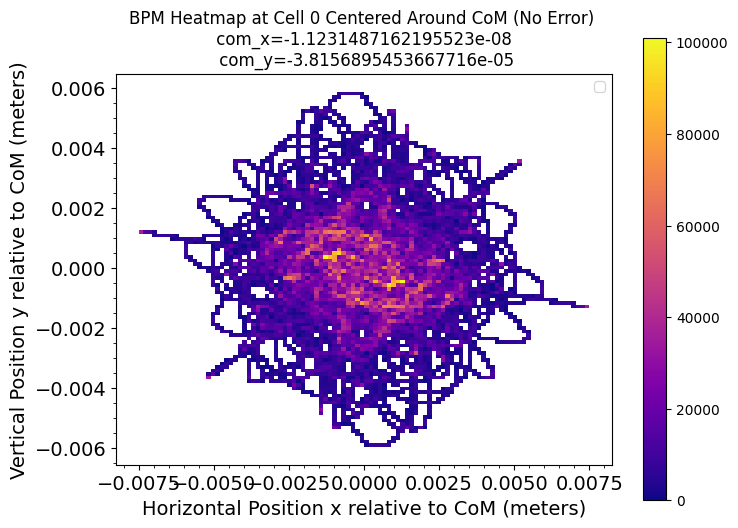

/home/aribra/jnps/thesis/lattice_error_net/synchrotron_simulator_gpu_Dataset_4D.py:2024: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


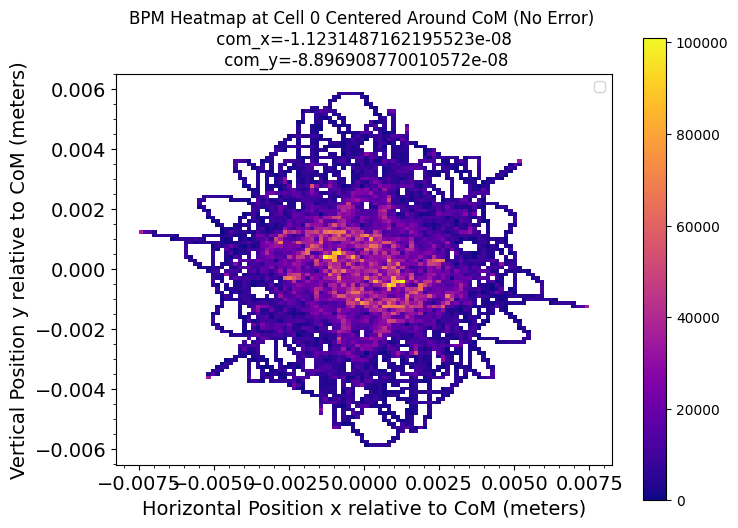

plot_bpm_comparison_last_images()/
	 CoM No error: X = 1.7346628675973482e-05, Y = 0.0002585641392541187
	 CoM With Error: X = 1.7346628675973482e-05, Y = 0.00022049621288814915
----
	 f'ΔX = 0.0000000 m, 0.00 micron
	 f'ΔY = -0.0000381 m, -38.07 micron
----
(100,)
(100,)
(100,)
(100,)
[array([-4.54255859e-03, -4.33738215e-03, -4.13220570e-03, -3.92702926e-03,
       -3.72185281e-03, -3.51667637e-03, -3.31149993e-03, -3.10632348e-03,
       -2.90114704e-03, -2.69597059e-03, -2.49079415e-03, -2.28561771e-03,
       -2.08044126e-03, -1.87526482e-03, -1.67008837e-03, -1.46491193e-03,
       -1.25973548e-03, -1.05455904e-03, -8.49382597e-04, -6.44206153e-04,
       -4.39029709e-04, -2.33853264e-04, -2.86768203e-05,  1.76499624e-04,
        3.81676068e-04,  5.86852512e-04,  7.92028956e-04,  9.97205400e-04,
        1.20238184e-03,  1.40755829e-03,  1.61273473e-03,  1.81791118e-03,
        2.02308762e-03,  2.22826406e-03,  2.43344051e-03,  2.63861695e-03,
        2.84379340e-03,  3.04896984e-

/home/aribra/jnps/thesis/lattice_error_net/synchrotron_simulator_gpu_Dataset_4D.py:2265: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  legend = plt.legend(facecolor='gray', edgecolor='white', framealpha=0.7)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


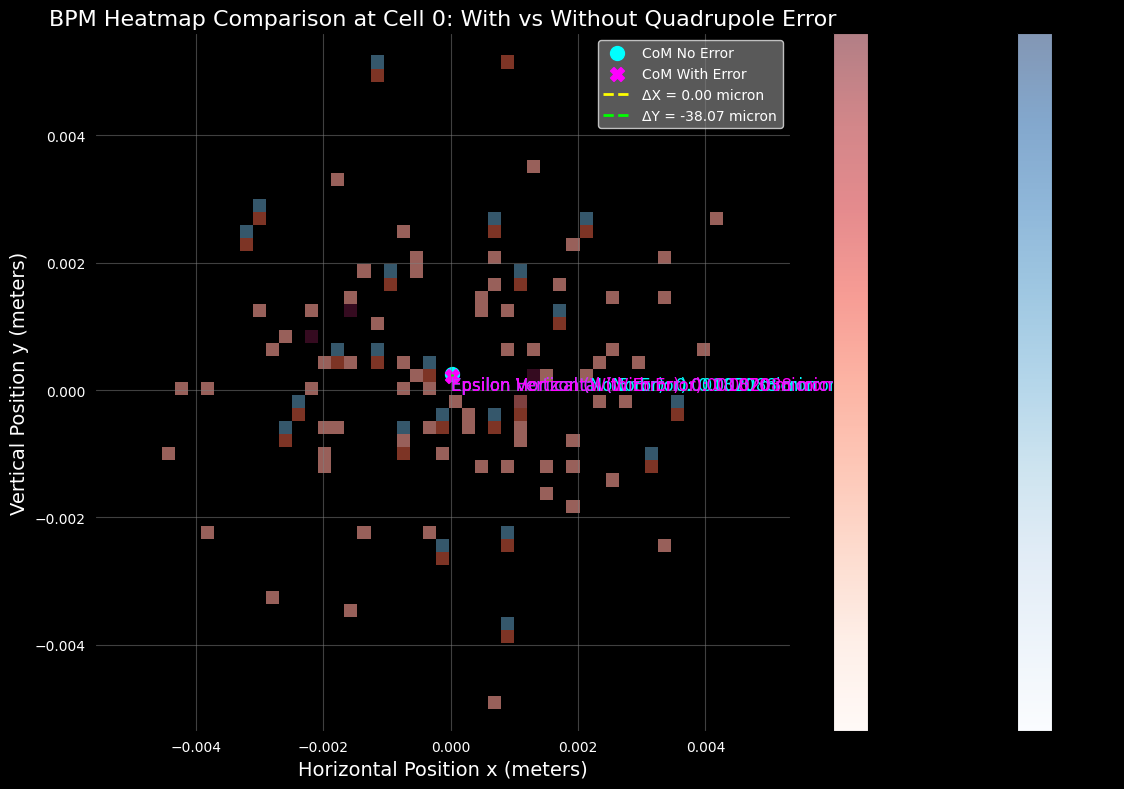

plot_bpm_comparison_last_images()/
	 CoM No error: X = 1.7346628675973482e-05, Y = 0.0002585641392541187
	 CoM With Error: X = 1.7346628675973482e-05, Y = 0.00025861030396980727
----
	 f'ΔX = 0.0000000 m, 0.00 micron
	 f'ΔY = 0.0000000 m, 0.05 micron
----
(100,)
(100,)
(100,)
(100,)
[array([-4.54255859e-03, -4.33814258e-03, -4.13372657e-03, -3.92931056e-03,
       -3.72489456e-03, -3.52047855e-03, -3.31606254e-03, -3.11164653e-03,
       -2.90723052e-03, -2.70281451e-03, -2.49839850e-03, -2.29398249e-03,
       -2.08956648e-03, -1.88515048e-03, -1.68073447e-03, -1.47631846e-03,
       -1.27190245e-03, -1.06748644e-03, -8.63070431e-04, -6.58654422e-04,
       -4.54238413e-04, -2.49822404e-04, -4.54063955e-05,  1.59009613e-04,
        3.63425622e-04,  5.67841631e-04,  7.72257640e-04,  9.76673649e-04,
        1.18108966e-03,  1.38550567e-03,  1.58992168e-03,  1.79433768e-03,
        1.99875369e-03,  2.20316970e-03,  2.40758571e-03,  2.61200172e-03,
        2.81641773e-03,  3.02083374e-03,

/home/aribra/jnps/thesis/lattice_error_net/synchrotron_simulator_gpu_Dataset_4D.py:2265: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  legend = plt.legend(facecolor='gray', edgecolor='white', framealpha=0.7)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


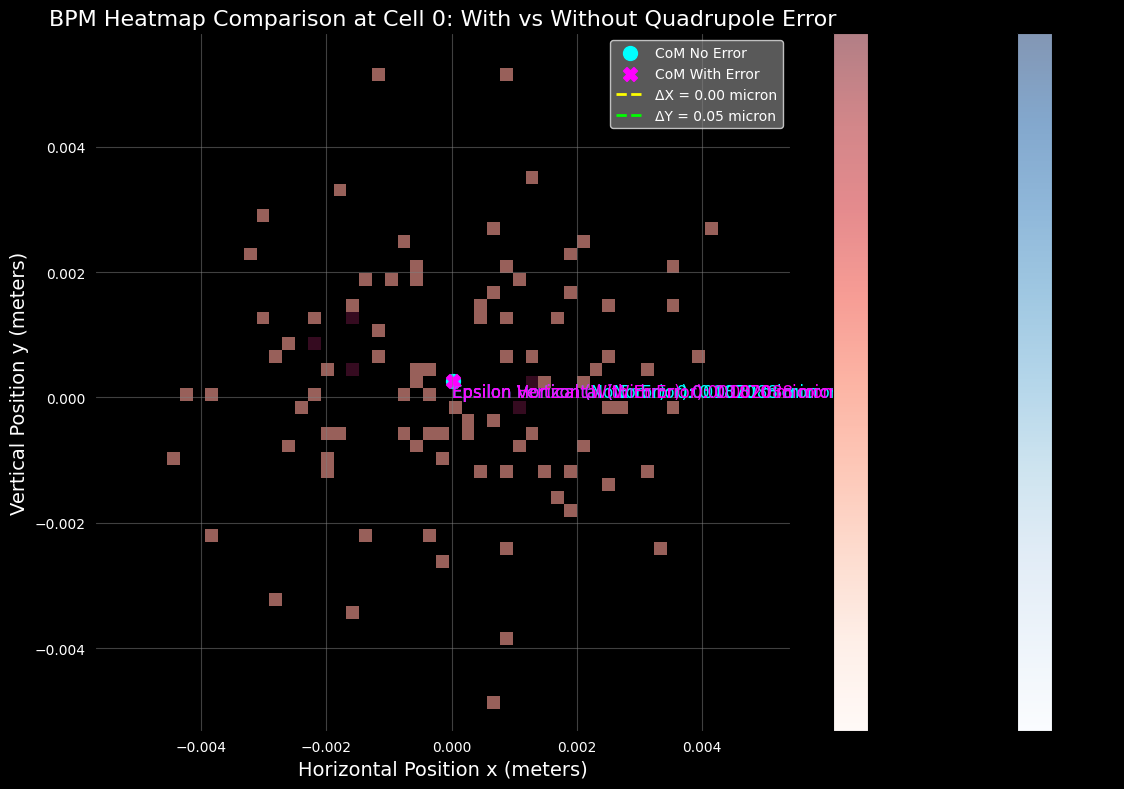

In [36]:
# Call the evaluation function
simulator_no_error, simulator_with_error, simulator_corrected = evaluate_model(model, base_configurations, common_parameters)

In [38]:
simulator_no_error.bpm_readings['x'].shape

(100, 1500, 8)

In [42]:
simulator_no_error.bpm_readings['x'][:, 0:1500, 0].shape

(100, 1500)

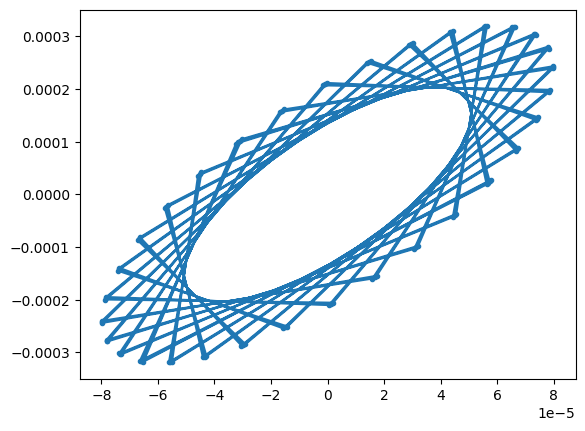

In [74]:
# plot(simulator_no_error.bpm_readings['x'][:, 0:1500, 0].mean(axis=0), '.')
# plot(simulator_no_error.bpm_readings['y'][:, 0:1500, 0].mean(axis=0), '.')
last_turn = 100
plot(simulator_no_error.bpm_readings['x'][:, 0:last_turn, 0].mean(axis=0), simulator_no_error.bpm_readings['y'][:, 0:last_turn, 0].mean(axis=0), '.-')

In [37]:
train_inputs.shape, train_targets.shape

(torch.Size([800, 101, 16]), torch.Size([800, 6]))

/home/aribra/jnps/thesis/lattice_error_net/synchrotron_simulator_gpu_Dataset_4D.py:2024: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


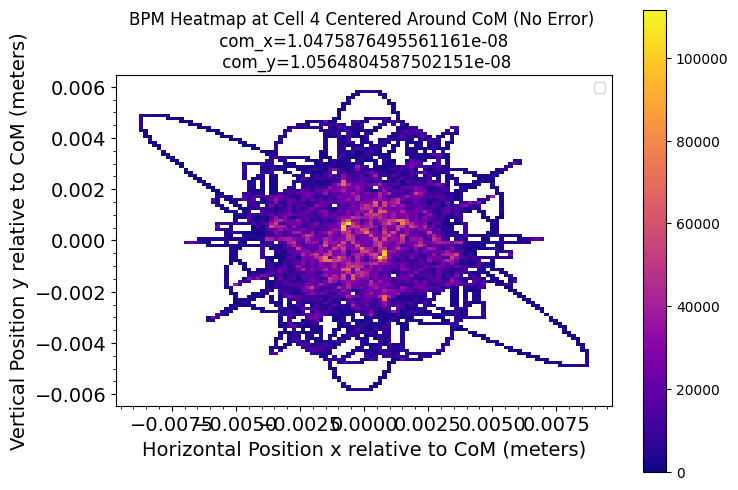

In [37]:
simulator_no_error.plot_bpm_heatmaps(cell_idx=4, save_label='0')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


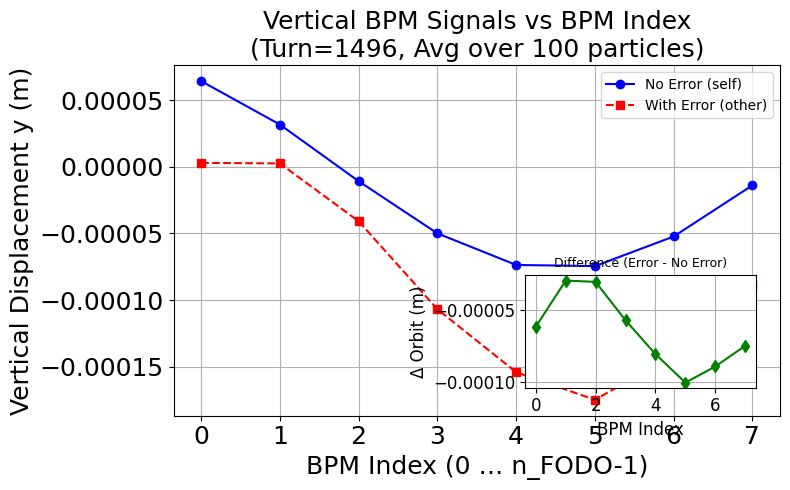

(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'Vertical BPM Signals vs BPM Index\n(Turn=1496, Avg over 100 particles)'}, xlabel='BPM Index (0 … n_FODO-1)', ylabel='Vertical Displacement y (m)'>)

In [38]:
simulator_no_error.compare_bpm_signal_vs_bpm_number(
    other_simulator=simulator_with_error,
    turn=1496,
    plane='vertical',
    average_over_particles=True,
    plot_difference=True,
    save_label="1496",
    fontsize=18
    
)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


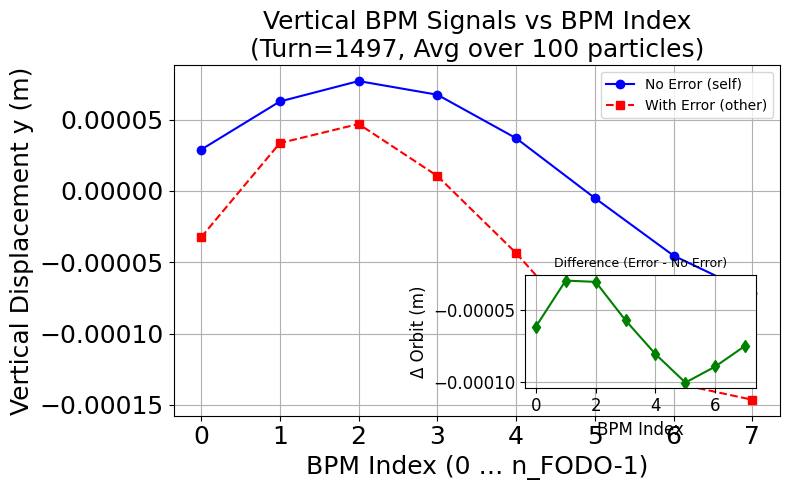

(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'Vertical BPM Signals vs BPM Index\n(Turn=1497, Avg over 100 particles)'}, xlabel='BPM Index (0 … n_FODO-1)', ylabel='Vertical Displacement y (m)'>)

In [39]:
simulator_no_error.compare_bpm_signal_vs_bpm_number(
    other_simulator=simulator_with_error,
    turn=1497,
    plane='vertical',
    average_over_particles=True,
    plot_difference=True,
    save_label="1497",
    fontsize=18
)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


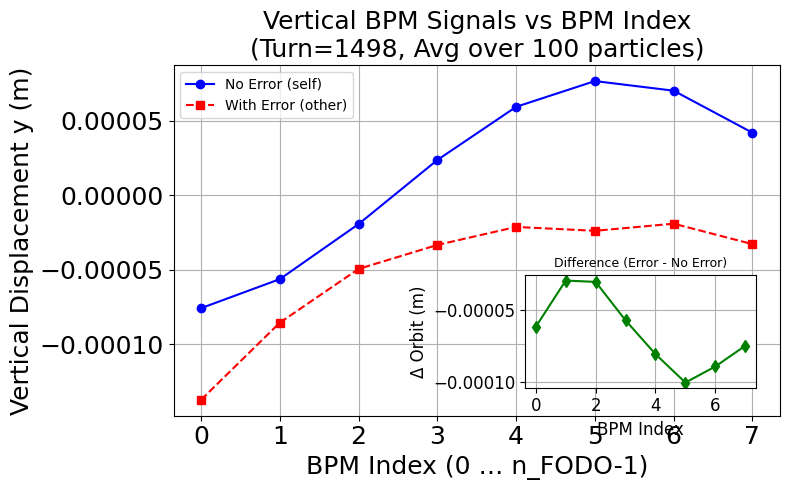

(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'Vertical BPM Signals vs BPM Index\n(Turn=1498, Avg over 100 particles)'}, xlabel='BPM Index (0 … n_FODO-1)', ylabel='Vertical Displacement y (m)'>)

In [40]:
simulator_no_error.compare_bpm_signal_vs_bpm_number(
    other_simulator=simulator_with_error,
    turn=1498,
    plane='vertical',
    average_over_particles=True,
    plot_difference=True,
    save_label="1498",
    fontsize=18
)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


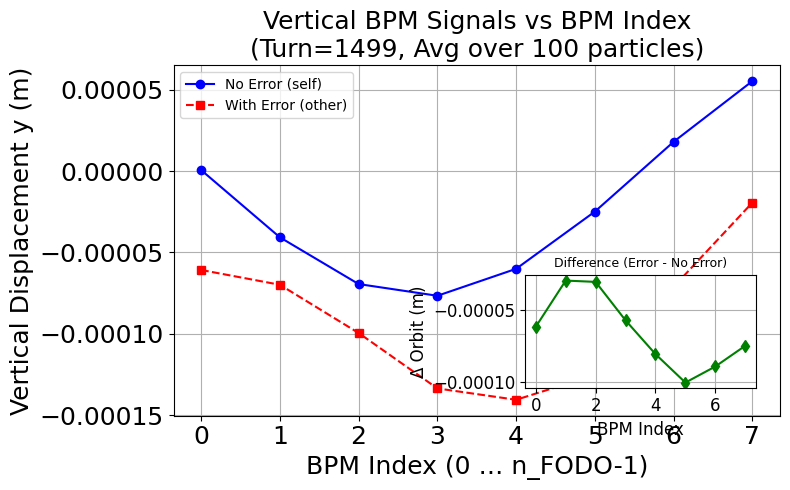

(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'Vertical BPM Signals vs BPM Index\n(Turn=1499, Avg over 100 particles)'}, xlabel='BPM Index (0 … n_FODO-1)', ylabel='Vertical Displacement y (m)'>)

In [41]:
simulator_no_error.compare_bpm_signal_vs_bpm_number(
    other_simulator=simulator_with_error,
    turn=1499,
    plane='vertical',
    average_over_particles=True,
    plot_difference=True,
    save_label="1499",
    fontsize=18
)


In [74]:


# viz_start_idx = simulator_corrected.n_turns - 100
# viz_end_idx = simulator_corrected.n_turns
# simulator_corrected.plot_comparison(simulator_no_error, cell_idx=cell_idx, viz_start_idx=viz_start_idx, viz_end_idx=viz_end_idx)

In [ ]:
bpm_idx = 0

In [ ]:
simulator_corrected.plot_comparison(simulator_no_error, cell_idx=bpm_idx, viz_start_idx=300 - 100, viz_end_idx=300)
bpm_idx += 1

In [ ]:
# simulator_with_error
# simulator_no_error



In [ ]:
# train_targets

In [ ]:
from pylab import *

plt.hist(target_tensors, bins = 10, rwidth=0.8)
# title('delta_y error  hist')
# grid()
# show()

# plt.hist(target_tensors_scaled, bins = 10, rwidth=0.8)
# title('delta_y error (scaled) hist')
# grid()

In [ ]:
from pylab import *

In [ ]:
target_tensors_scaled.min(), target_tensors_scaled.max()

In [ ]:
plot(target_tensors_scaled, '.')

In [ ]:
dataset_scalers['target_scaler'].inverse_transform(target_tensors_scaled)[:10]

In [ ]:
target_tensors[:10]

In [ ]:
torch.save(train_inputs, "train_inputs.pt")
torch.save(target_tensors, "target_tensors.pt")

In [ ]:
train_inputs.shape

In [ ]:
# train_inputs[0]

In [ ]:
train_targets.shape

In [ ]:
plot(train_inputs[580:600, :, 0], train_inputs[580:600, :, 1], 'x');